### Data Fetching from Grafana

In [43]:
import requests
import pandas as pd
import datetime
import os
import pytz

# Function to fetch data from Grafana
def fetch_grafana_data(expr, start, end, step, grafana_url, api_key):
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json",
    }

    params = {
        "query": expr,
        "start": start,
        "end": end,
        "step": step,
    }

    response = requests.get(grafana_url, headers=headers, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch data for query {expr}: {response.status_code} - {response.text}")
        return None

# Process results into a DataFrame
def process_results(results, query_name):
    est_tz = pytz.timezone('US/Eastern')  # Eastern Standard Time (UTC-5)
    data = {}
    for metric in results.get("data", {}).get("result", []):
        time_series = metric.get("values", [])
        for timestamp, value in time_series:
            time_key = datetime.datetime.utcfromtimestamp(float(timestamp)).replace(tzinfo=pytz.utc)
            est_timestamp = time_key.astimezone(est_tz)
            formatted_timestamp = est_timestamp.strftime('%Y-%m-%d %H:%M:%S')  # Formatting the timestamp
            if formatted_timestamp not in data:
                data[formatted_timestamp] = {}
            # Multiply the value by pod_count for relevant queries (CPU and Memory)
            if "CPU" in query_name or "Memory" in query_name:
                data[formatted_timestamp][query_name] = float(value) * 100
            else:
                data[formatted_timestamp][query_name] = float(value)
    return data

# Function to fetch and process all queries from Grafana and save to CSV
def fetch_and_process_grafana_data(output_csv, grafana_url, api_key):
    # Queries and Parameters
    QUERIES = [
        {
            "expr": 'instance:node_cpu_utilisation:rate5m{job="node-exporter", instance="192.168.132.123:9100", cluster=""} != 0',
            "name": "Cluster CPU",
            "step": "60s",
        },
        {
            "expr": 'instance:node_memory_utilisation:ratio{job="node-exporter", instance="192.168.132.123:9100", cluster=""} != 0',
            "name": "Cluster Memory",
            "step": "60s",
        },
        {
            "expr": 'sum(rate(container_cpu_usage_seconds_total{namespace="default", pod=~"order-management-depl-.*"}[1m])) / sum(kube_pod_container_resource_requests{resource="cpu", namespace="default", pod=~"order-management-depl-.*"})',
            "name": "Order Management CPU Usage",
            "step": "60s"
        },
        {
            "expr": 'sum(rate(container_cpu_usage_seconds_total{namespace="default", pod=~"user-account-depl-.*"}[1m])) / sum(kube_pod_container_resource_requests{resource="cpu", namespace="default", pod=~"user-account-depl-.*"})',
            "name": "User Account CPU Usage",
            "step": "60s"
        },
        {
            "expr": 'sum(rate(container_cpu_usage_seconds_total{namespace="default", pod=~"product-catalog-depl-.*"}[1m])) / sum(kube_pod_container_resource_requests{resource="cpu", namespace="default", pod=~"product-catalog-depl-.*"})',
            "name": "Product Catalog CPU Usage",
            "step": "60s"
        },
        {
            "expr": 'sum(rate(container_cpu_usage_seconds_total{namespace="default", pod=~"review-and-rating-depl-.*"}[1m])) / sum(kube_pod_container_resource_requests{resource="cpu", namespace="default", pod=~"review-and-rating-depl-.*"})',
            "name": "Review Rating CPU Usage",
            "step": "60s"
        },
        {
            "expr": 'sum(rate(container_cpu_usage_seconds_total{namespace="default", pod=~"shipping-and-logistics-depl-.*"}[1m])) / sum(kube_pod_container_resource_requests{resource="cpu", namespace="default", pod=~"shipping-and-logistics-depl-.*"})',
            "name": "Shipping Logistics CPU Usage",
            "step": "60s"
        },
        {
            "expr": 'sum(rate(container_cpu_usage_seconds_total{namespace="default", pod=~"payment-processing-depl-.*"}[1m])) / sum(kube_pod_container_resource_requests{resource="cpu", namespace="default", pod=~"payment-processing-depl-.*"})',
            "name": "Payment Processing CPU Usage",
            "step": "60s"
        },
        {
            "expr": 'sum(container_memory_working_set_bytes{job="kubelet", metrics_path="/metrics/cadvisor", cluster="", container!="", image!="", pod=~"order-management-depl-.*"}) / sum(kube_pod_container_resource_requests{job="kube-state-metrics", cluster="",  resource="memory", pod=~"order-management-depl-.*"})',
            "name": "Order Management Memory Usage",
            "step": "60s"
        },
        {
            "expr": 'sum(container_memory_working_set_bytes{job="kubelet", metrics_path="/metrics/cadvisor", cluster="", container!="", image!="", pod=~"user-account-depl-.*"}) / sum(kube_pod_container_resource_requests{job="kube-state-metrics", cluster="",  resource="memory", pod=~"user-account-depl-.*"})',
            "name": "User Account Memory Usage",
            "step": "60s"
        },
        {
            "expr": 'sum(container_memory_working_set_bytes{job="kubelet", metrics_path="/metrics/cadvisor", cluster="", container!="", image!="", pod=~"payment-processing-depl-.*"}) / sum(kube_pod_container_resource_requests{job="kube-state-metrics", cluster="",  resource="memory", pod=~"payment-processing-depl-.*"})',
            "name": "Payment Processing Memory Usage",
            "step": "60s"
        },
        {
            "expr": 'sum(container_memory_working_set_bytes{job="kubelet", metrics_path="/metrics/cadvisor", cluster="", container!="", image!="", pod=~"shipping-and-logistics-depl-.*"}) / sum(kube_pod_container_resource_requests{job="kube-state-metrics", cluster="",  resource="memory", pod=~"shipping-and-logistics-depl-.*"})',
            "name": "Shipping Logistics Memory Usage",
            "step": "60s"
        },
        {
            "expr": 'sum(container_memory_working_set_bytes{job="kubelet", metrics_path="/metrics/cadvisor", cluster="", container!="", image!="", pod=~"product-catalog-depl-.*"}) / sum(kube_pod_container_resource_requests{job="kube-state-metrics", cluster="",  resource="memory", pod=~"product-catalog-depl-.*"})',
            "name": "Product Catalog Memory Usage",
            "step": "60s"
        },
        {
            "expr": 'sum(container_memory_working_set_bytes{job="kubelet", metrics_path="/metrics/cadvisor", cluster="", container!="", image!="", pod=~"review-and-rating-depl-.*"}) / sum(kube_pod_container_resource_requests{job="kube-state-metrics", cluster="",  resource="memory", pod=~"review-and-rating-depl-.*"})',
            "name": "Review Rating Memory Usage",
            "step": "60s"
        },
        {
            "expr": 'count(kube_pod_info{namespace="default", pod=~"order-management-depl-.*"})',
            "step": "1m0s",
            "name": "Order Management Pod Count"
        },
        {
            "expr": 'count(kube_pod_info{namespace="default", pod=~"product-catalog-depl-.*"})',
            "step": "1m0s",
            "name": "Product Catalog Pod Count"
        },
        {
            "expr": 'count(kube_pod_info{namespace="default", pod=~"payment-processing-depl-.*"})',
            "step": "1m0s",
            "name": "Payment Processing Pod Count"
        },
        {
            "expr": 'count(kube_pod_info{namespace="default", pod=~"review-and-rating-depl-.*"})',
            "step": "1m0s",
            "name": "Review Rating Pod Count"
        },
        {
            "expr": 'count(kube_pod_info{namespace="default", pod=~"shipping-and-logistics-depl-.*"})',
            "step": "1m0s",
            "name": "Shipping Logistics Pod Count"
        },
        {
            "expr": 'count(kube_pod_info{namespace="default", pod=~"user-account-depl-.*"})',
            "step": "1m0s",
            "name": "User Account Pod Count"
        },
        {
            "expr": 'sum(increase(nginx_ingress_controller_requests{namespace="ingress-nginx",exported_service="order-management-srv"}[1m]))',
            "step": "1m0s",
            "name": "Order Management Request Count"
        },
        {
            "expr": 'sum(increase(nginx_ingress_controller_requests{namespace="ingress-nginx",exported_service="product-catalog-srv"}[1m]))',
            "step": "1m0s",
            "name": "Product Catalog Request Count"
        },
        {
            "expr": 'sum(increase(nginx_ingress_controller_requests{namespace="ingress-nginx",exported_service="user-account-srv"}[1m]))',
            "step": "1m0s",
            "name": "User Account Request Count"
        },
        {
            "expr": 'sum(increase(nginx_ingress_controller_requests{namespace="ingress-nginx",exported_service="payment-processing-srv"}[1m]))',
            "step": "1m0s",
            "name": "Payment Processing Request Count"
        },
        {
            "expr": 'sum(increase(nginx_ingress_controller_requests{namespace="ingress-nginx",exported_service="review-and-rating-srv"}[1m]))',
            "step": "1m0s",
            "name": "Review Rating Request Count"
        },
        {
            "expr": 'sum(increase(nginx_ingress_controller_requests{namespace="ingress-nginx",exported_service="shipping-and-logistics-srv"}[1m]))',
            "step": "1m0s",
            "name": "Shipping Logistics Request Count"
        },
        {
            "expr": 'sum(increase(nginx_ingress_controller_requests{namespace="ingress-nginx", exported_service="order-management-srv", status=~"5.."}[1m]))',
            "step": "1m0s",
            "name": "Order Management 5xx Failures"
        },
        {
            "expr": 'sum(increase(nginx_ingress_controller_requests{namespace="ingress-nginx", exported_service="product-catalog-srv", status=~"5.."}[1m]))',
            "step": "1m0s",
            "name": "Product Catalog 5xx Failures"
        },
        {
            "expr": 'sum(increase(nginx_ingress_controller_requests{namespace="ingress-nginx", exported_service="user-account-srv", status=~"5.."}[1m]))',
            "step": "1m0s",
            "name": "User Account 5xx Failures"
        },
        {
            "expr": 'sum(increase(nginx_ingress_controller_requests{namespace="ingress-nginx", exported_service="payment-processing-srv", status=~"5.."}[1m]))',
            "step": "1m0s",
            "name": "Payment Processing 5xx Failures"
        },
        {
            "expr": 'sum(increase(nginx_ingress_controller_requests{namespace="ingress-nginx", exported_service="review-and-rating-srv", status=~"5.."}[1m]))',
            "step": "1m0s",
            "name": "Review Rating 5xx Failures"
        },
        {
            "expr": 'sum(increase(nginx_ingress_controller_requests{namespace="ingress-nginx", exported_service="shipping-and-logistics-srv", status=~"5.."}[1m]))',
            "step": "1m0s",
            "name": "Shipping Logistics 5xx Failures"
        },
    ]

    # Set the current time in UTC-5 (Eastern Standard Time)
    est_tz = pytz.timezone('US/Eastern')  # Eastern Standard Time (UTC-5)
    now_est = datetime.datetime.now(est_tz)

    # Manual start time calculation (48 hours ago)
    start_time = now_est - datetime.timedelta(days=2)  # Subtract 2 days from now

    # Convert both start_time and now_est to UTC-5 timezone
    start_time_utc5 = start_time.replace(tzinfo=est_tz)  # Set the timezone for start_time
    end_time_utc5 = now_est.replace(tzinfo=est_tz)  # Set the timezone for current time

    # Convert to Unix timestamps in UTC-5
    start_time = start_time_utc5.timestamp()
    end_time = end_time_utc5.timestamp()

    # Time range for the last 2 days (2880 datapoints = 48 hours)
    # now = datetime.datetime.utcnow()
    # start_time = (now - datetime.timedelta(days=2)).timestamp()  # 48 hours back
    # end_time = now.timestamp()

    # Consolidate all query results into a single DataFrame
    all_data = {}
    for query in QUERIES:
        result = fetch_grafana_data(query["expr"], start_time, end_time, query["step"], grafana_url, api_key)
        if result:
            query_data = process_results(result, query["name"])
            for timestamp, metrics in query_data.items():
                if timestamp not in all_data:
                    all_data[timestamp] = {}
                all_data[timestamp].update(metrics)

    # Convert to DataFrame
    df = pd.DataFrame.from_dict(all_data, orient="index").sort_index()
    df.index.name = "Time"

    # Save to CSV
    df.to_csv(output_csv)
    print(f"Data saved to {output_csv}")

### Data Loading

In [33]:
import torch
import os
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from darts import TimeSeries
from darts.models import NHiTSModel
from sklearn.preprocessing import MinMaxScaler
from darts.dataprocessing.transformers import Scaler
import pickle
from sklearn.preprocessing import StandardScaler, LabelEncoder

import warnings

warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

def load_data(file_path: str):
    # Define the columns to include in the new DataFrame
    order_columns_to_include = [
        'Time',
        'Cluster CPU',
        'Cluster Memory',
        'Order Management CPU Usage',
        'Order Management Memory Usage',
        'Order Management Request Count',
        'Order Management 5xx Failures',
        'Order Management Pod Count'
    ]
    product_columns_to_include = [
        'Time',
        'Cluster CPU',
        'Cluster Memory',
        'Product Catalog CPU Usage',
        'Product Catalog Memory Usage',
        'Product Catalog Request Count',
        'Product Catalog 5xx Failures',
        'Product Catalog Pod Count'
    ]
    shipping_columns_to_include = [
        'Time',
        'Cluster CPU',
        'Cluster Memory',
        'Shipping Logistics CPU Usage',
        'Shipping Logistics Memory Usage',
        'Shipping Logistics Request Count',
        'Shipping Logistics 5xx Failures',
        'Shipping Logistics Pod Count'
    ]
    user_columns_to_include = [
        'Time',
        'Cluster CPU',
        'Cluster Memory',
        'User Account CPU Usage',
        'User Account Memory Usage',
        'User Account Request Count',
        'User Account 5xx Failures',
        'User Account Pod Count'
    ]
    reviews_columns_to_include = [
        'Time',
        'Cluster CPU',
        'Cluster Memory',
        'Review Rating CPU Usage',
        'Review Rating Memory Usage',
        'Review Rating Request Count',
        'Review Rating 5xx Failures',
        'Review Rating Pod Count'
    ]
    payment_columns_to_include = [
        'Time',
        'Cluster CPU',
        'Cluster Memory',
        'Payment Processing CPU Usage',
        'Payment Processing Memory Usage',
        'Payment Processing Request Count',
        'Payment Processing 5xx Failures',
        'Payment Processing Pod Count'
    ]

    # Creating dataframes for each service
    order_df = pd.read_csv(file_path, usecols=order_columns_to_include)
    product_df = pd.read_csv(file_path, usecols=product_columns_to_include)
    user_df = pd.read_csv(file_path, usecols=user_columns_to_include)
    reviews_df = pd.read_csv(file_path, usecols=reviews_columns_to_include)
    shipping_df = pd.read_csv(file_path, usecols=shipping_columns_to_include)
    payment_df = pd.read_csv(file_path, usecols=payment_columns_to_include)

    # Fill NaN values with 0
    order_df.fillna(0, inplace=True)
    product_df.fillna(0, inplace=True)
    user_df.fillna(0, inplace=True)
    reviews_df.fillna(0, inplace=True)
    shipping_df.fillna(0, inplace=True)
    payment_df.fillna(0, inplace=True)

    # Convert 'Time' to datetime and set it as the index for each DataFrame
    for df in [order_df, product_df, user_df, reviews_df, shipping_df, payment_df]:
        df['Time'] = pd.to_datetime(df['Time'])
        df.set_index('Time', inplace=True)

    return order_df, product_df, user_df, reviews_df, shipping_df, payment_df

### Data Smoothing

In [34]:
# Function to apply triple exponential smoothing on each column
def apply_triple_exponential_smoothing(df, seasonal_periods, trend_type='add', seasonal_type='add'):
    smoothed_df = pd.DataFrame(index=df.index)
    
    for column in df.columns:
        if column != 'Time':  # Avoid applying smoothing to the 'Time' column
            model = ExponentialSmoothing(df[column],
                                         trend=trend_type,
                                         seasonal=seasonal_type,
                                         seasonal_periods=seasonal_periods)
            smoothed_series = model.fit(smoothing_level=0.4, smoothing_trend=0.001, smoothing_seasonal=0.001).fittedvalues
            smoothed_df[column] = smoothed_series
            
    return smoothed_df

def plot_original_vs_smoothed(df, smoothed_df, title):
    plt.figure(figsize=(24, 20))
    columns = df.columns[:-1]  # Exclude 'Time' column
    
    for i, column in enumerate(columns, start=1):
        plt.subplot(7, 1, i)  # Adjust the subplot grid if necessary
        plt.plot(df.index, df[column], label='Original', color='blue')  # Use df.index for Time
        plt.plot(smoothed_df.index, smoothed_df[column], label='Smoothed', color='red')  # Use smoothed_df.index
        plt.title(f"{title} - {column}")
        plt.legend()

    plt.tight_layout()
    plt.savefig(f"{title} - Denoising - Final Pipeline")
    plt.show()

def data_smoothing(order_df, product_df, user_df, reviews_df, shipping_df, payment_df, seasonal_periods):
    # Apply smoothing and visualize for each service
    order_smoothed = apply_triple_exponential_smoothing(order_df, seasonal_periods)
    plot_original_vs_smoothed(order_df, order_smoothed, 'Order Management')

    product_smoothed = apply_triple_exponential_smoothing(product_df, seasonal_periods)
    plot_original_vs_smoothed(product_df, product_smoothed, 'Product Catalog')

    user_smoothed = apply_triple_exponential_smoothing(user_df, seasonal_periods)
    plot_original_vs_smoothed(user_df, user_smoothed, 'User Account')

    reviews_smoothed = apply_triple_exponential_smoothing(reviews_df, seasonal_periods)
    plot_original_vs_smoothed(reviews_df, reviews_smoothed, 'Review Rating')

    shipping_smoothed = apply_triple_exponential_smoothing(shipping_df, seasonal_periods)
    plot_original_vs_smoothed(shipping_df, shipping_smoothed, 'Shipping Logistics')

    payment_smoothed = apply_triple_exponential_smoothing(payment_df, seasonal_periods)
    plot_original_vs_smoothed(payment_df, payment_smoothed, 'Payment Processing')

    # Adding 'Time' column back for each smoothed DataFrame
    order_smoothed['Time'] = order_smoothed.index
    product_smoothed['Time'] = product_smoothed.index
    user_smoothed['Time'] = user_smoothed.index
    reviews_smoothed['Time'] = reviews_smoothed.index
    shipping_smoothed['Time'] = shipping_smoothed.index
    payment_smoothed['Time'] = payment_smoothed.index

    return (order_smoothed, product_smoothed, user_smoothed, reviews_smoothed, shipping_smoothed, payment_smoothed)


### Feature Engineering & Scaling

In [35]:
def preprocess_and_scale_features(order_smoothed, reviews_smoothed, payment_smoothed, 
                                  user_smoothed, shipping_smoothed, product_smoothed):
    # 1. CPU Usage (Across all services)
    series_order_cpu = TimeSeries.from_dataframe(order_smoothed, 'Time', 'Order Management CPU Usage')
    series_review_cpu = TimeSeries.from_dataframe(reviews_smoothed, 'Time', 'Review Rating CPU Usage')
    series_payment_cpu = TimeSeries.from_dataframe(payment_smoothed, 'Time', 'Payment Processing CPU Usage')
    series_user_cpu = TimeSeries.from_dataframe(user_smoothed, 'Time', 'User Account CPU Usage')
    series_shipping_cpu = TimeSeries.from_dataframe(shipping_smoothed, 'Time', 'Shipping Logistics CPU Usage')
    series_product_cpu = TimeSeries.from_dataframe(product_smoothed, 'Time', 'Product Catalog CPU Usage')

    # Stack all services' CPU usage into one feature-centric time series
    series_cpu_all_services = (
        series_order_cpu.stack(series_review_cpu)
        .stack(series_payment_cpu)
        .stack(series_user_cpu)
        .stack(series_shipping_cpu)
        .stack(series_product_cpu)
    )

    # Normalize/Scale the data for CPU usage
    scaler_cpu = Scaler(MinMaxScaler())
    series_cpu_all_services_scaled = scaler_cpu.fit_transform(series_cpu_all_services)

    # 2. Memory Usage (Across all services)
    series_order_memory = TimeSeries.from_dataframe(order_smoothed, 'Time', 'Order Management Memory Usage')
    series_review_memory = TimeSeries.from_dataframe(reviews_smoothed, 'Time', 'Review Rating Memory Usage')
    series_payment_memory = TimeSeries.from_dataframe(payment_smoothed, 'Time', 'Payment Processing Memory Usage')
    series_user_memory = TimeSeries.from_dataframe(user_smoothed, 'Time', 'User Account Memory Usage')
    series_shipping_memory = TimeSeries.from_dataframe(shipping_smoothed, 'Time', 'Shipping Logistics Memory Usage')
    series_product_memory = TimeSeries.from_dataframe(product_smoothed, 'Time', 'Product Catalog Memory Usage')

    # Stack all services' memory usage into one feature-centric time series
    series_memory_all_services = (
        series_order_memory.stack(series_review_memory)
        .stack(series_payment_memory)
        .stack(series_user_memory)
        .stack(series_shipping_memory)
        .stack(series_product_memory)
    )

    # Normalize/Scale the data for Memory usage
    scaler_memory = Scaler(MinMaxScaler())
    series_memory_all_services_scaled = scaler_memory.fit_transform(series_memory_all_services)

    # 3. Pod Count (Across all services)
    series_order_pod_count = TimeSeries.from_dataframe(order_smoothed, 'Time', 'Order Management Pod Count')
    series_review_pod_count = TimeSeries.from_dataframe(reviews_smoothed, 'Time', 'Review Rating Pod Count')
    series_payment_pod_count = TimeSeries.from_dataframe(payment_smoothed, 'Time', 'Payment Processing Pod Count')
    series_user_pod_count = TimeSeries.from_dataframe(user_smoothed, 'Time', 'User Account Pod Count')
    series_shipping_pod_count = TimeSeries.from_dataframe(shipping_smoothed, 'Time', 'Shipping Logistics Pod Count')
    series_product_pod_count = TimeSeries.from_dataframe(product_smoothed, 'Time', 'Product Catalog Pod Count')

    # Stack all services' pod count into one feature-centric time series
    series_pod_count_all_services = (
        series_order_pod_count.stack(series_review_pod_count)
        .stack(series_payment_pod_count)
        .stack(series_user_pod_count)
        .stack(series_shipping_pod_count)
        .stack(series_product_pod_count)
    )

    # Normalize/Scale the data for Pod Count
    scaler_pod_count = Scaler(MinMaxScaler())
    series_pod_count_all_services_scaled = scaler_pod_count.fit_transform(series_pod_count_all_services)

    # 4. Request Count (Across all services)
    series_order_request_count = TimeSeries.from_dataframe(order_smoothed, 'Time', 'Order Management Request Count')
    series_review_request_count = TimeSeries.from_dataframe(reviews_smoothed, 'Time', 'Review Rating Request Count')
    series_payment_request_count = TimeSeries.from_dataframe(payment_smoothed, 'Time', 'Payment Processing Request Count')
    series_user_request_count = TimeSeries.from_dataframe(user_smoothed, 'Time', 'User Account Request Count')
    series_shipping_request_count = TimeSeries.from_dataframe(shipping_smoothed, 'Time', 'Shipping Logistics Request Count')
    series_product_request_count = TimeSeries.from_dataframe(product_smoothed, 'Time', 'Product Catalog Request Count')

    # Stack all services' request count into one feature-centric time series
    series_request_count_all_services = (
        series_order_request_count.stack(series_review_request_count)
        .stack(series_payment_request_count)
        .stack(series_user_request_count)
        .stack(series_shipping_request_count)
        .stack(series_product_request_count)
    )

    # Normalize/Scale the data for Request Count
    scaler_request_count = Scaler(MinMaxScaler())
    series_request_count_all_services_scaled = scaler_request_count.fit_transform(series_request_count_all_services)

    # 5. 5xx Failures (Across all services)
    series_order_5xx_failures = TimeSeries.from_dataframe(order_smoothed, 'Time', 'Order Management 5xx Failures')
    series_review_5xx_failures = TimeSeries.from_dataframe(reviews_smoothed, 'Time', 'Review Rating 5xx Failures')
    series_payment_5xx_failures = TimeSeries.from_dataframe(payment_smoothed, 'Time', 'Payment Processing 5xx Failures')
    series_user_5xx_failures = TimeSeries.from_dataframe(user_smoothed, 'Time', 'User Account 5xx Failures')
    series_shipping_5xx_failures = TimeSeries.from_dataframe(shipping_smoothed, 'Time', 'Shipping Logistics 5xx Failures')
    series_product_5xx_failures = TimeSeries.from_dataframe(product_smoothed, 'Time', 'Product Catalog 5xx Failures')

    # Stack all services' 5xx failures into one feature-centric time series
    series_5xx_failures_all_services = (
        series_order_5xx_failures.stack(series_review_5xx_failures)
        .stack(series_payment_5xx_failures)
        .stack(series_user_5xx_failures)
        .stack(series_shipping_5xx_failures)
        .stack(series_product_5xx_failures)
    )

    # Normalize/Scale the data for 5xx Failures
    scaler_5xx_failures = Scaler(MinMaxScaler())
    series_5xx_failures_all_services_scaled = scaler_5xx_failures.fit_transform(series_5xx_failures_all_services)

    # 2. Cluster-Level Features (Common to All Services)
    # Fetch Cluster CPU and Memory from Order Management data (since it's common across all services)
    series_cluster_cpu = TimeSeries.from_dataframe(order_smoothed, 'Time', 'Cluster CPU')
    series_cluster_memory = TimeSeries.from_dataframe(order_smoothed, 'Time', 'Cluster Memory')

    # Normalize/Scale the data for Cluster CPU and Memory
    scaler_cluster_cpu = Scaler(MinMaxScaler())
    scaler_cluster_memory = Scaler(MinMaxScaler())
    series_cluster_cpu_scaled = scaler_cluster_cpu.fit_transform(series_cluster_cpu)
    series_cluster_memory_scaled = scaler_cluster_memory.fit_transform(series_cluster_memory)

    # Define a dictionary for scalers
    scalers_dict = {
        "5xx_failures": scaler_5xx_failures,
        "request_count": scaler_request_count,
        "memory": scaler_memory,
        "cpu": scaler_cpu,
        "pod_count": scaler_pod_count,
        "cluster_cpu": scaler_cluster_cpu,
        "cluster_memory": scaler_cluster_memory,
    }

    # Return scaled series and scalers dictionary
    return (
        series_cpu_all_services_scaled,
        series_memory_all_services_scaled,
        series_request_count_all_services_scaled,
        series_pod_count_all_services_scaled,
        series_5xx_failures_all_services_scaled,
        series_cluster_cpu_scaled,
        series_cluster_memory_scaled,
        scalers_dict
    )


### Forecasting

In [36]:
def perform_forecasting(cpu_scaled, memory_scaled, request_count_scaled, pod_count_scaled, failures_scaled, cluster_cpu_scaled, cluster_memory_scaled, scalers_dict):
    # Directory where the models are saved
    model_dir = os.path.expanduser("~/Documents/models_sharcnet_v2/")
    model_dir_2 = os.path.expanduser("~/Documents/models/")
    model_dir_3 = os.path.expanduser("~/Documents/memory_model/")

    # Prediction steps
    pred_steps = 480

    # Define the prediction date range
    start_date = dt(2025, 9, 24)
    end_date = dt(2025, 9, 25)

    cutoff_dict = {
    "5xx_failures": 0.12,
    "request_count": 0.12,
    "memory": 0.12,
    "cpu": 0.12,
    "pod_count": 0.07,
    "cluster_cpu": 0.08,
    "cluster_memory": 0.08,
    }


    # Prepare a dictionary for models based on your feature-centric approach
    models_dict = {
        "5xx_failures": NHiTSModel.load(os.path.join(model_dir_2, "5xx_failures_model.pt")),
        "request_count": NHiTSModel.load(os.path.join(model_dir_2, "request_count_model.pt")),
        "memory": NHiTSModel.load(os.path.join(model_dir_3, "memory_model.pt")),
        "cpu": NHiTSModel.load(os.path.join(model_dir_2, "cpu_model.pt")),
        "pod_count": NHiTSModel.load(os.path.join(model_dir, "pod_count_model.pt")),
        "cluster_cpu": NHiTSModel.load(os.path.join(model_dir, "cluster_cpu_model.pt")),
        "cluster_memory": NHiTSModel.load(os.path.join(model_dir, "cluster_memory_model.pt")),
    }

    # Prepare a dictionary for input series
    scaled_series_dict = {
        "5xx_failures": failures_scaled,
        "request_count": request_count_scaled,
        "memory": memory_scaled,
        "cpu": cpu_scaled,
        "pod_count": pod_count_scaled,
        "cluster_cpu": cluster_cpu_scaled,
        "cluster_memory": cluster_memory_scaled,
    }

    # Explicit mapping of feature names to their corresponding column names in your data
    column_name_mapping = {
        "5xx_failures": [
            "Order Management 5xx Failures",
            "Review Rating 5xx Failures",
            "Payment Processing 5xx Failures",
            "User Account 5xx Failures",
            "Shipping Logistics 5xx Failures",
            "Product Catalog 5xx Failures"
        ],
        "request_count": [
            "Order Management Request Count",
            "Review Rating Request Count",
            "Payment Processing Request Count",
            "User Account Request Count",
            "Shipping Logistics Request Count",
            "Product Catalog Request Count"
        ],
        "memory": [
            "Order Management Memory Usage",
            "Review Rating Memory Usage",
            "Payment Processing Memory Usage",
            "User Account Memory Usage",
            "Shipping Logistics Memory Usage",
            "Product Catalog Memory Usage"
        ],
        "cpu": [
            "Order Management CPU Usage",
            "Review Rating CPU Usage",
            "Payment Processing CPU Usage",
            "User Account CPU Usage",
            "Shipping Logistics CPU Usage",
            "Product Catalog CPU Usage"
        ],
        "pod_count": [
            "Order Management Pod Count",
            "Review Rating Pod Count",
            "Payment Processing Pod Count",
            "User Account Pod Count",
            "Shipping Logistics Pod Count",
            "Product Catalog Pod Count"
        ],
        "cluster_cpu": [
            "Cluster CPU"
        ],
        "cluster_memory": [
            "Cluster Memory"
        ]
    }

    # Create a 7x1 subplot to visualize the series
    fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(24, 18))
    fig.tight_layout(pad=5.0)

    # Create a dictionary to store separate DataFrames for each service
    service_dataframes = {}

    # Function to apply FFT with a customizable cutoff frequency
    def fft_filter(series, cutoff):
        # Perform FFT
        fft_vals = np.fft.fft(series)
        frequencies = np.fft.fftfreq(len(series))
    
        # Zero out frequencies above the cutoff
        fft_vals[np.abs(frequencies) > cutoff] = 0
    
        # Inverse FFT to get the filtered signal
        filtered_series = np.fft.ifft(fft_vals).real
        return filtered_series


    # Loop through each feature and perform predictions
    for idx, (feature_name, model) in enumerate(models_dict.items()):
        # Prepare the input series
        pred_input = scaled_series_dict[feature_name][:-pred_steps]  # Input data for prediction
        print(f"Length of pred_input for {feature_name}: {len(pred_input)}")  # Debug print

        # Get the appropriate scaler for this feature
        scaler = scalers_dict[feature_name]
        cutoff = cutoff_dict[feature_name]
        
        # Predict the next `pred_steps` points
        pred_series = model.predict(n=pred_steps, series=pred_input)

        # Inverse transform the series to get actual values
        input_series = scaler.inverse_transform(pred_input).pd_dataframe()
        predicted_series = scaler.inverse_transform(pred_series).pd_dataframe()

        # Apply FFT filter to smooth the predictions
        filtered_series = predicted_series.copy()
        for column in predicted_series.columns:
            filtered_series[column] = fft_filter(predicted_series[column].values, cutoff)

        # Loop through all columns for this feature and plot each one
        for column in column_name_mapping[feature_name]:
            # Plotting the series and include the model name in the label
            sns.lineplot(ax=axes[idx], x=input_series.index, y=input_series[column], label=f'Input Series ({feature_name}) - {column}')
            sns.lineplot(ax=axes[idx], x=filtered_series.index, y=filtered_series[column], label=f'Filtered Series ({feature_name}) - {column}')

        axes[idx].set_title(f"Feature: {feature_name}", fontsize=16, fontweight='bold')
        axes[idx].legend(loc='upper left')
        axes[idx].set_xlim(left=start_date, right=end_date)

        for column in column_name_mapping[feature_name]:
            service_name = " ".join(column.split()[:2])   # Get service name from the column name
            if service_name not in service_dataframes:
                service_dataframes[service_name] = pd.DataFrame(index=predicted_series.index)

            # Store predictions
            service_dataframes[service_name][f"{column}"] = filtered_series[column]

    # Now, add the cluster CPU and memory data into the first five service DataFrames
    cluster_cpu_df = service_dataframes.pop('Cluster CPU', pd.DataFrame())
    cluster_memory_df = service_dataframes.pop('Cluster Memory', pd.DataFrame())

    # Move the cluster data to each of the first five service DataFrames
    for service_name in list(service_dataframes.keys())[:6]:  # Only for the first five services
        service_dataframes[service_name]["Cluster CPU"] = cluster_cpu_df
        service_dataframes[service_name]["Cluster Memory"] = cluster_memory_df

    # Display the plot
    plt.show()

    return service_dataframes


### Classification

In [37]:
# Directory for saved classification models
classification_model_dir = "classification_models"

# Function to load a model based on the service and model type
def load_model(service_name, model_name):
    model_filename = f"{classification_model_dir}/{service_name.replace(' ', '_')}_{model_name}.pkl"
    with open(model_filename, 'rb') as model_file:
        return pickle.load(model_file)

# Classification function
def perform_classification(service_dataframes):
    # Array of classification models to use
    classification_models = ["Random Forest"]
    
    # Dictionary to hold classified results
    classified_results = {}

    # Process and classify predictions for each service
    for service_name, df in service_dataframes.items():
        classified_results[service_name] = {}

        # Loop through each model type
        for model_name in classification_models:
            # Load the model
            model = load_model(service_name, model_name)
            
            # Load the scaler
            scaler_filename = f"{classification_model_dir}/{service_name.replace(' ', '_')}_{model_name}_scaler.pkl"
            with open(scaler_filename, 'rb') as scaler_file:
                scaler = pickle.load(scaler_file)

            # Load the label encoder
            label_encoder_filename = f"{classification_model_dir}/{service_name.replace(' ', '_')}_{model_name}_encoder.pkl"
            with open(label_encoder_filename, 'rb') as le_file:
                label_encoder = pickle.load(le_file)

            # Preprocess the prediction data
            features = df.columns.tolist()  # Ensure this matches your feature set
            X = scaler.transform(df[features])  # Standardize the data

            # Classify using the model
            y_pred_encoded = model.predict(X)  # Predict encoded labels
            y_pred = label_encoder.inverse_transform(y_pred_encoded)  # Decode labels

            # Store predictions and add to DataFrame
            classified_results[service_name][model_name] = y_pred
            df["Scaling Action"] = y_pred

    # Print classified results example for "Order Management" service
    print("Order Management - Random Forest classifications:")
    if "Order Management" in classified_results:
        print(classified_results["Order Management"]["Random Forest"])

    # Optional: Save the classified DataFrames to files
    for service_name, df in service_dataframes.items():
        df['Time'] = df.index
        df.to_csv(f"classified_predictions_{service_name}.csv", index=False)
        print(f"Classified predictions saved for {service_name}")

    return classified_results

### Main Execution

Data saved to grafana_data.csv


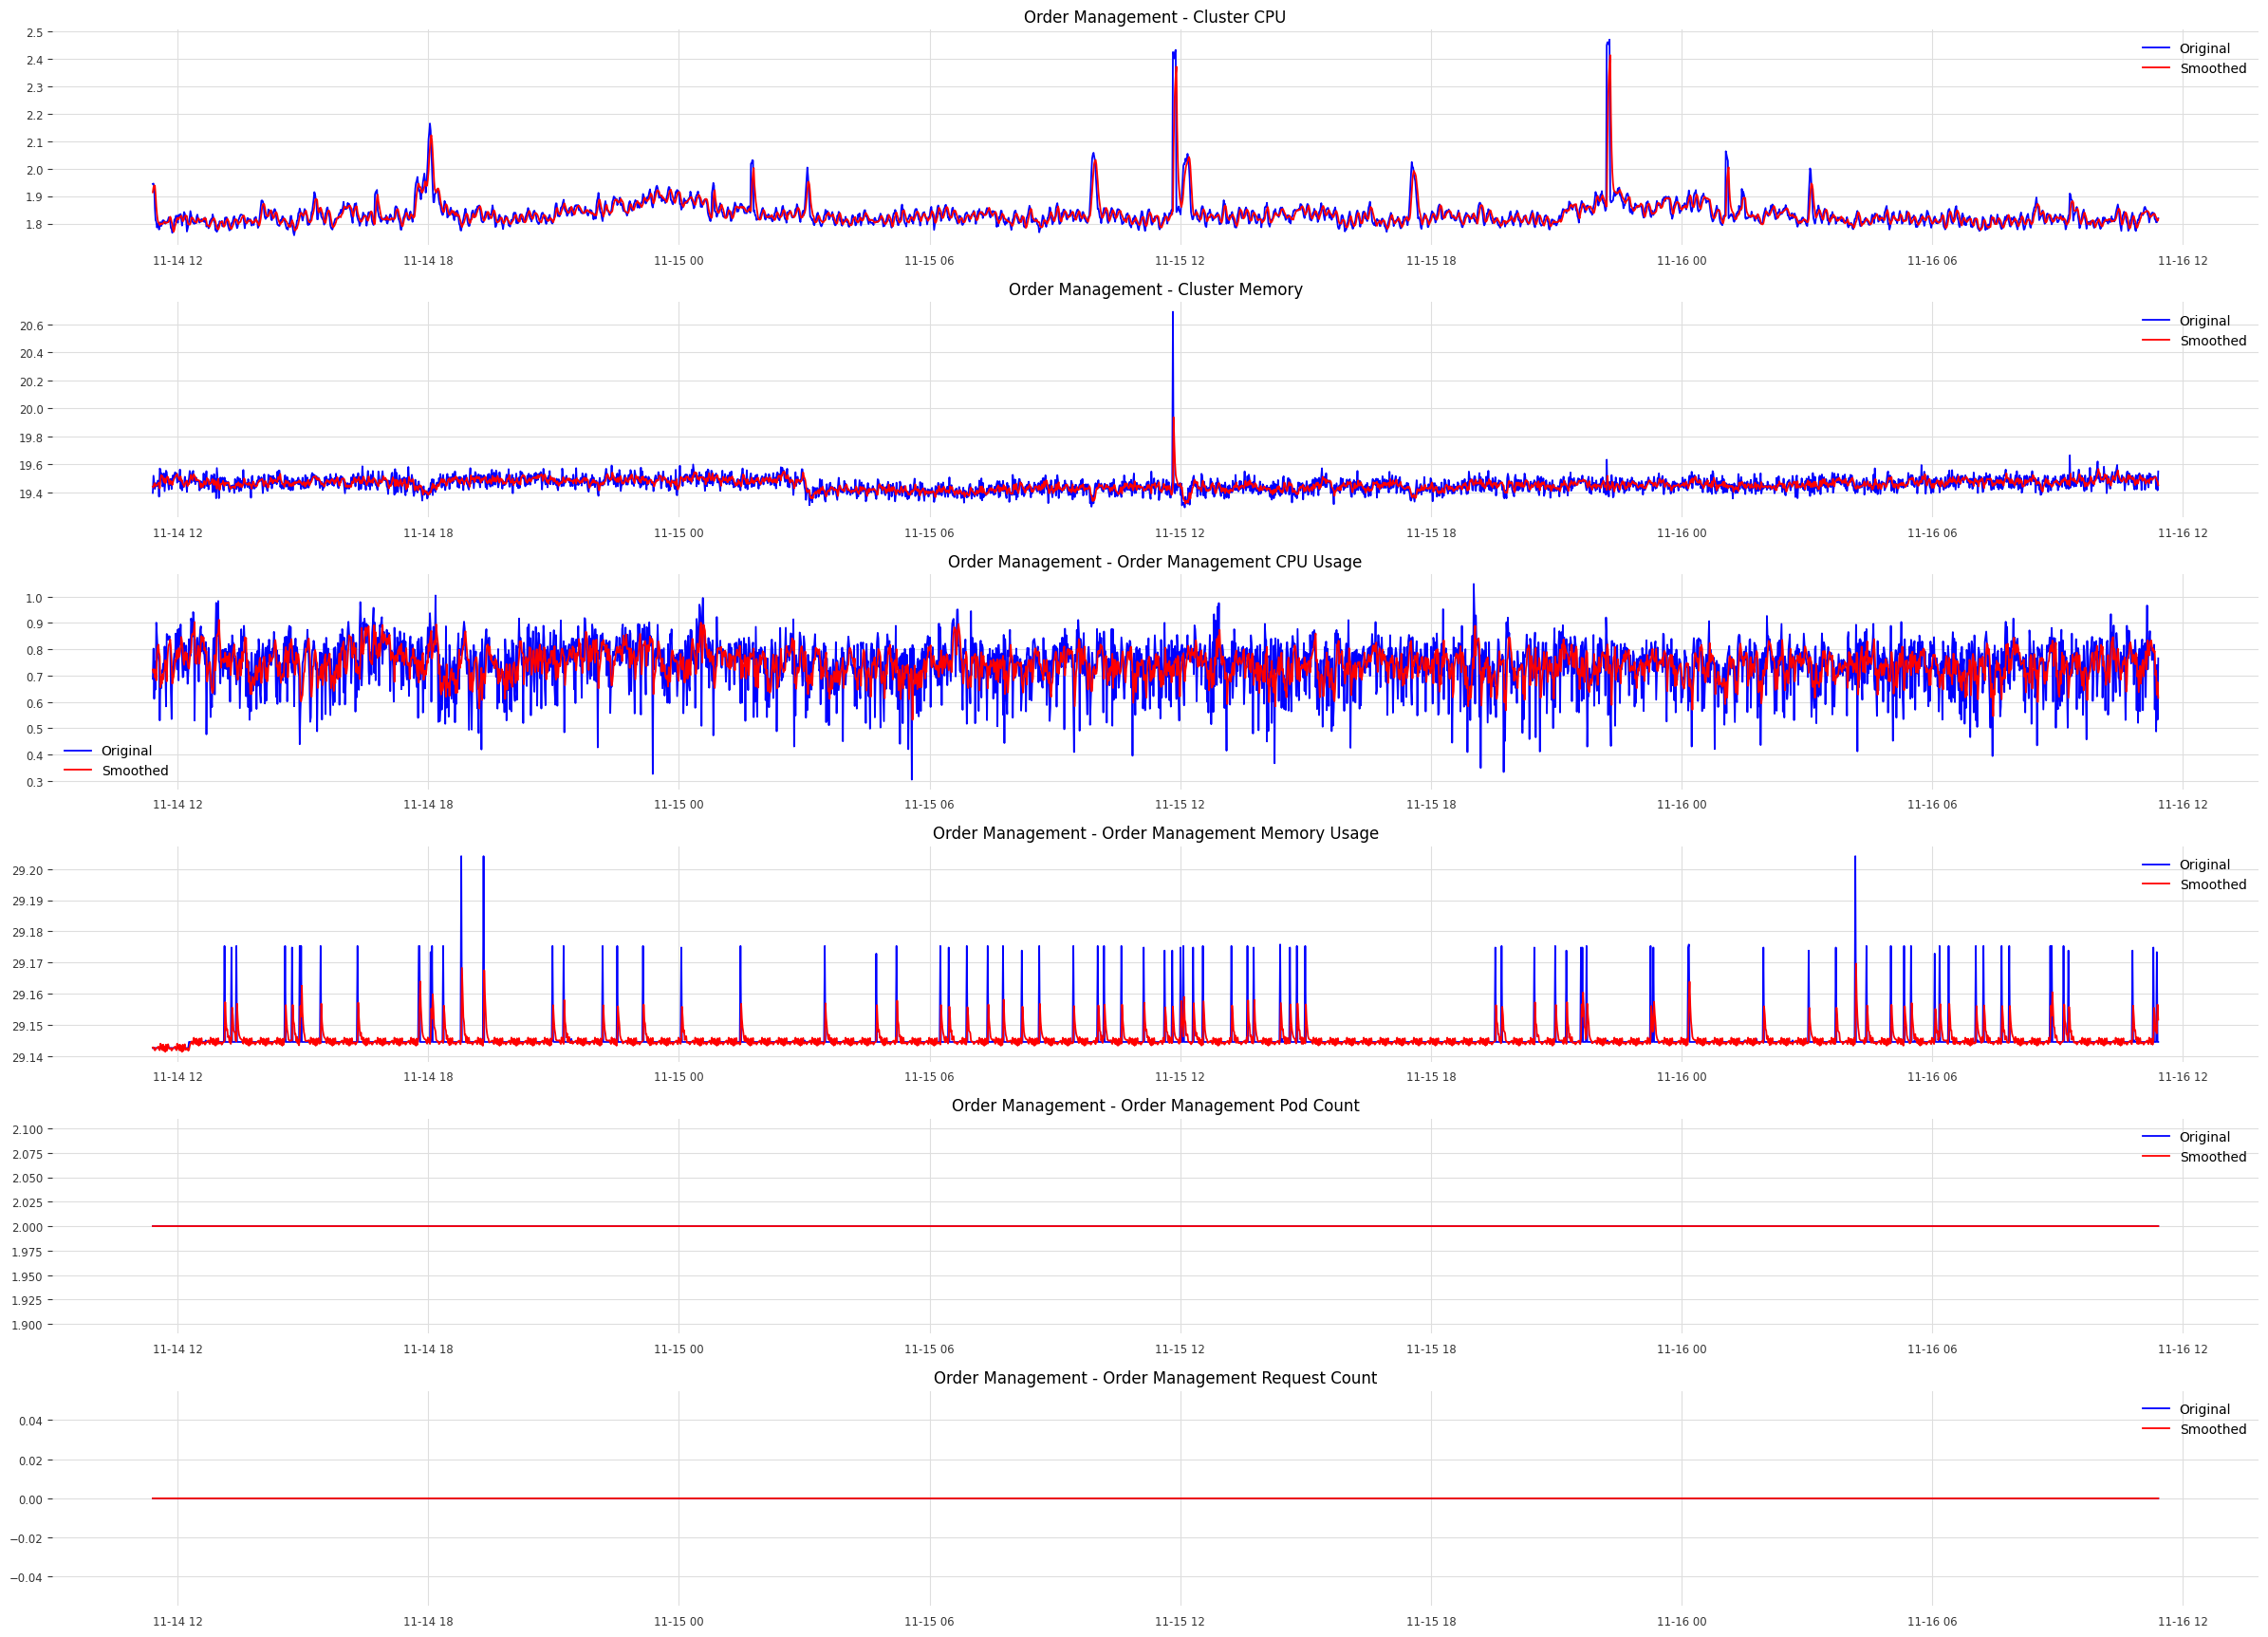

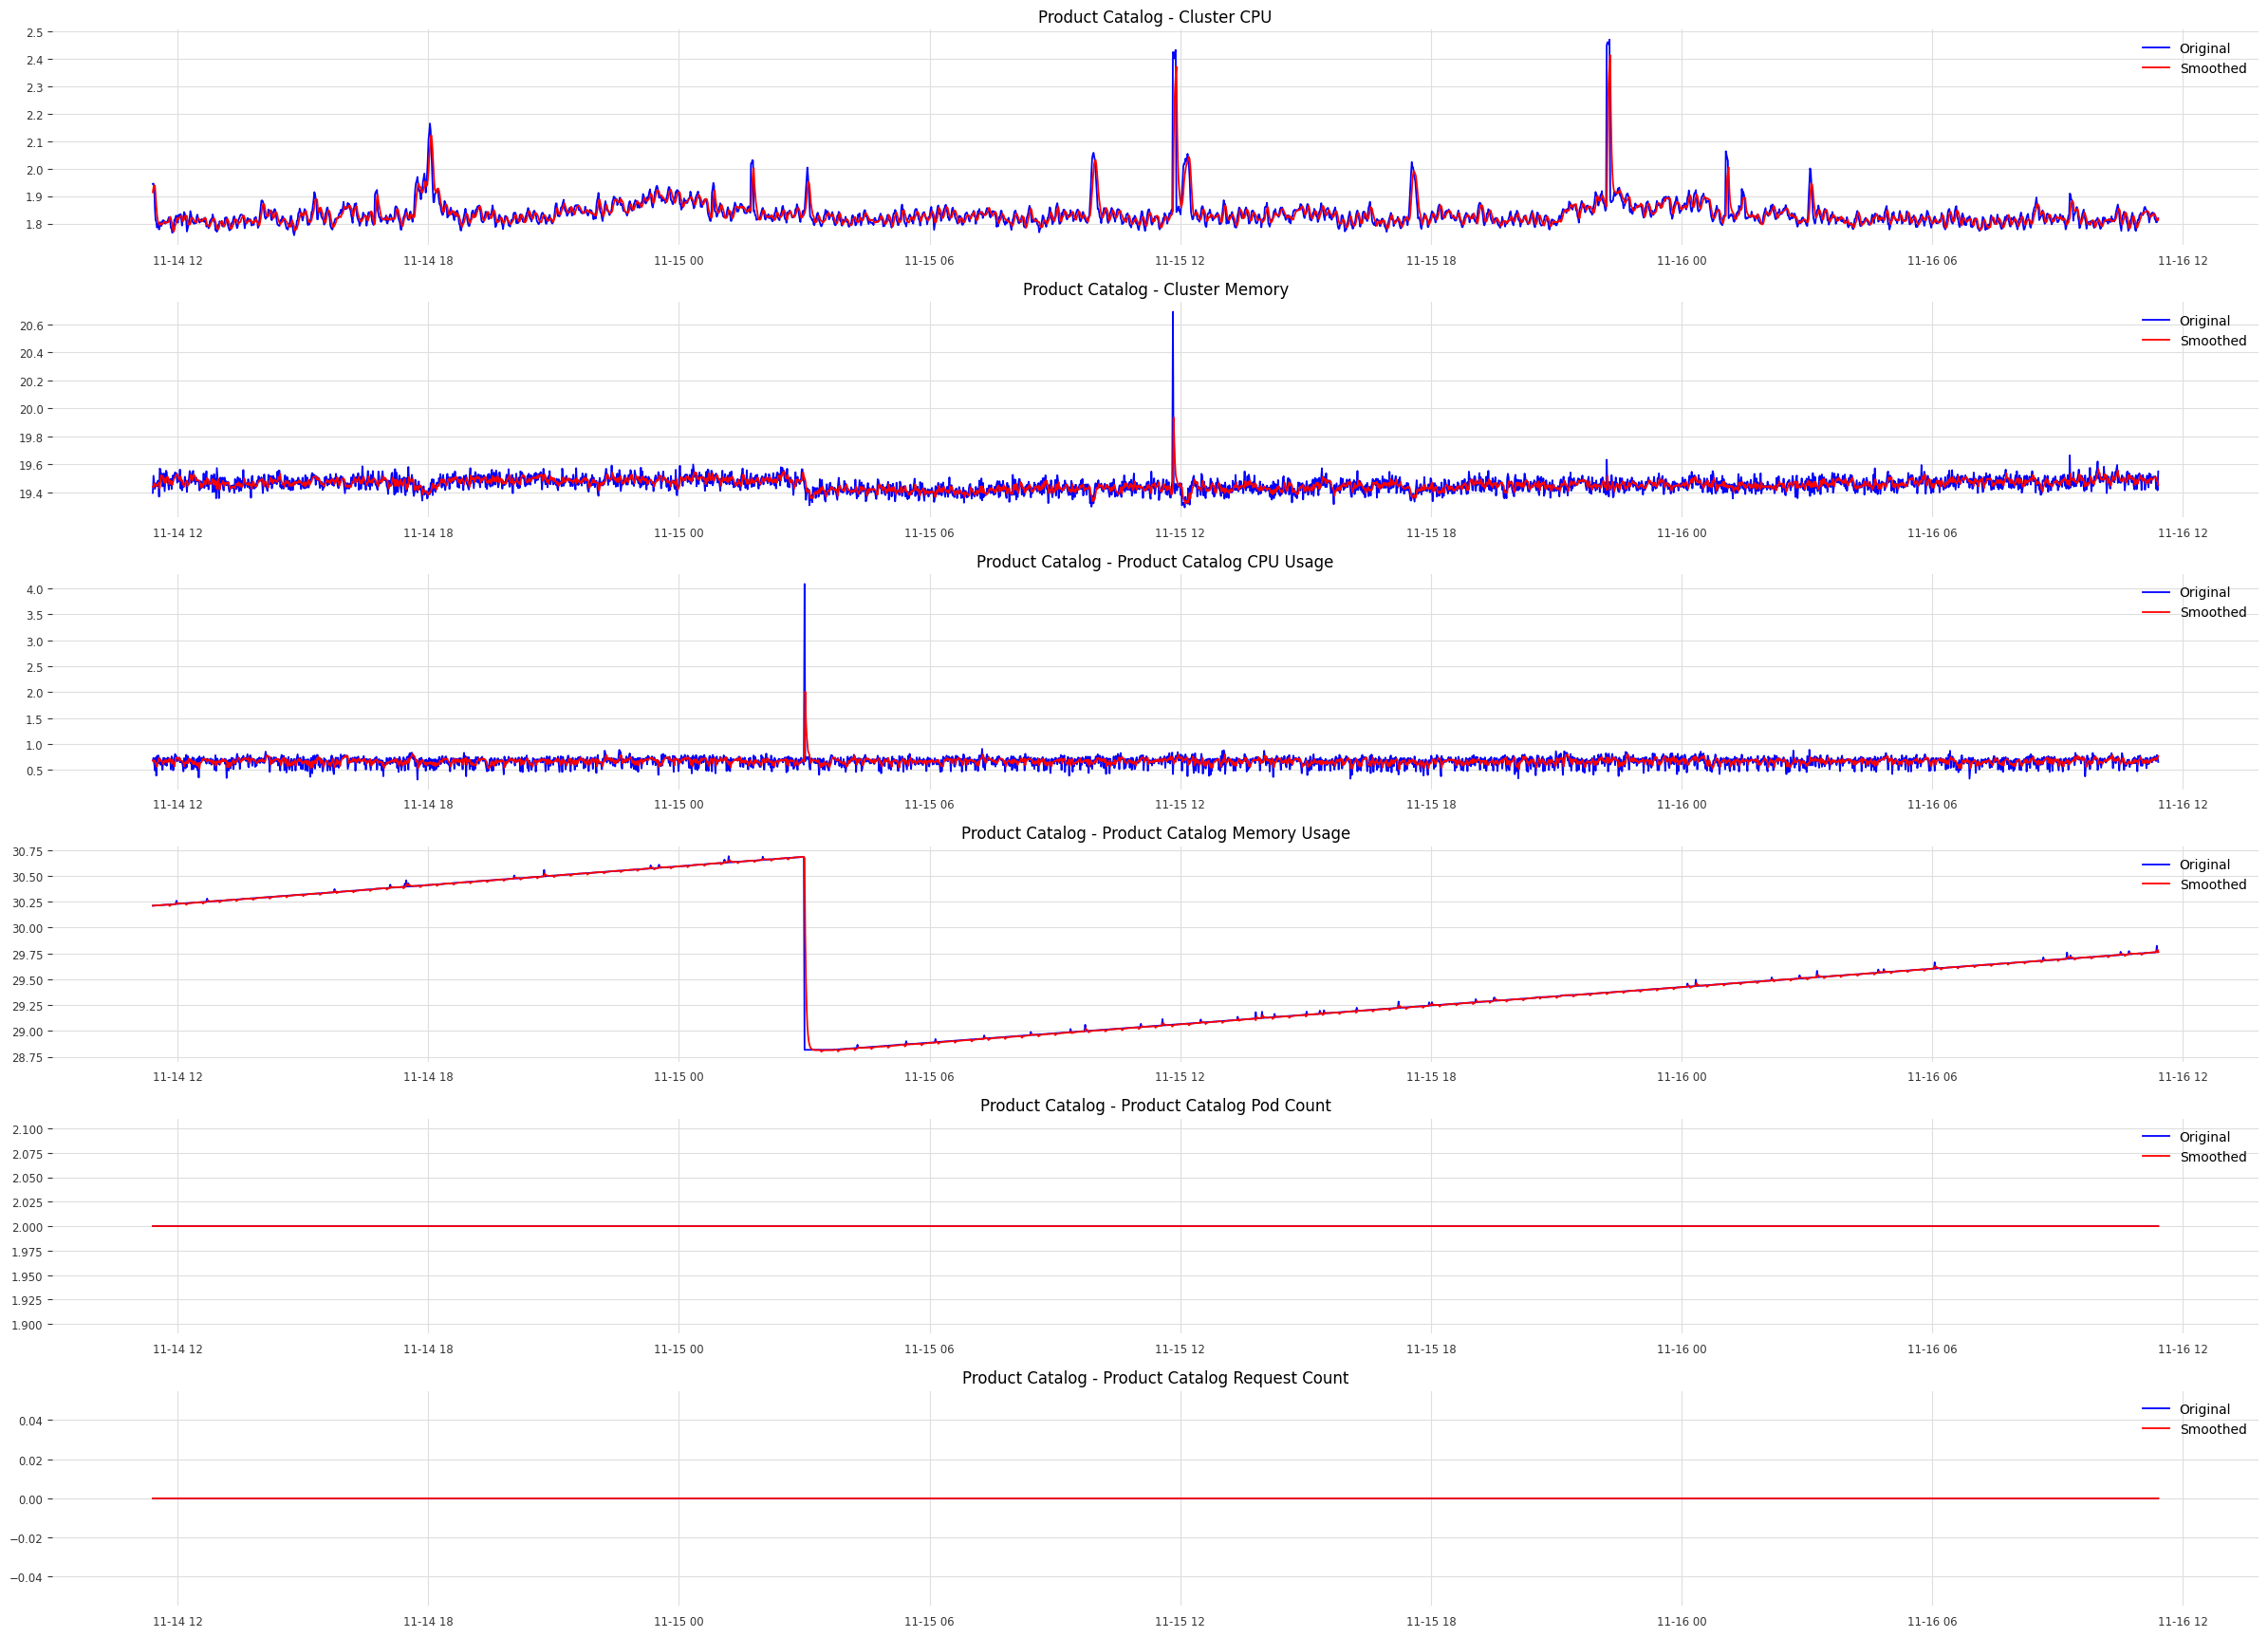

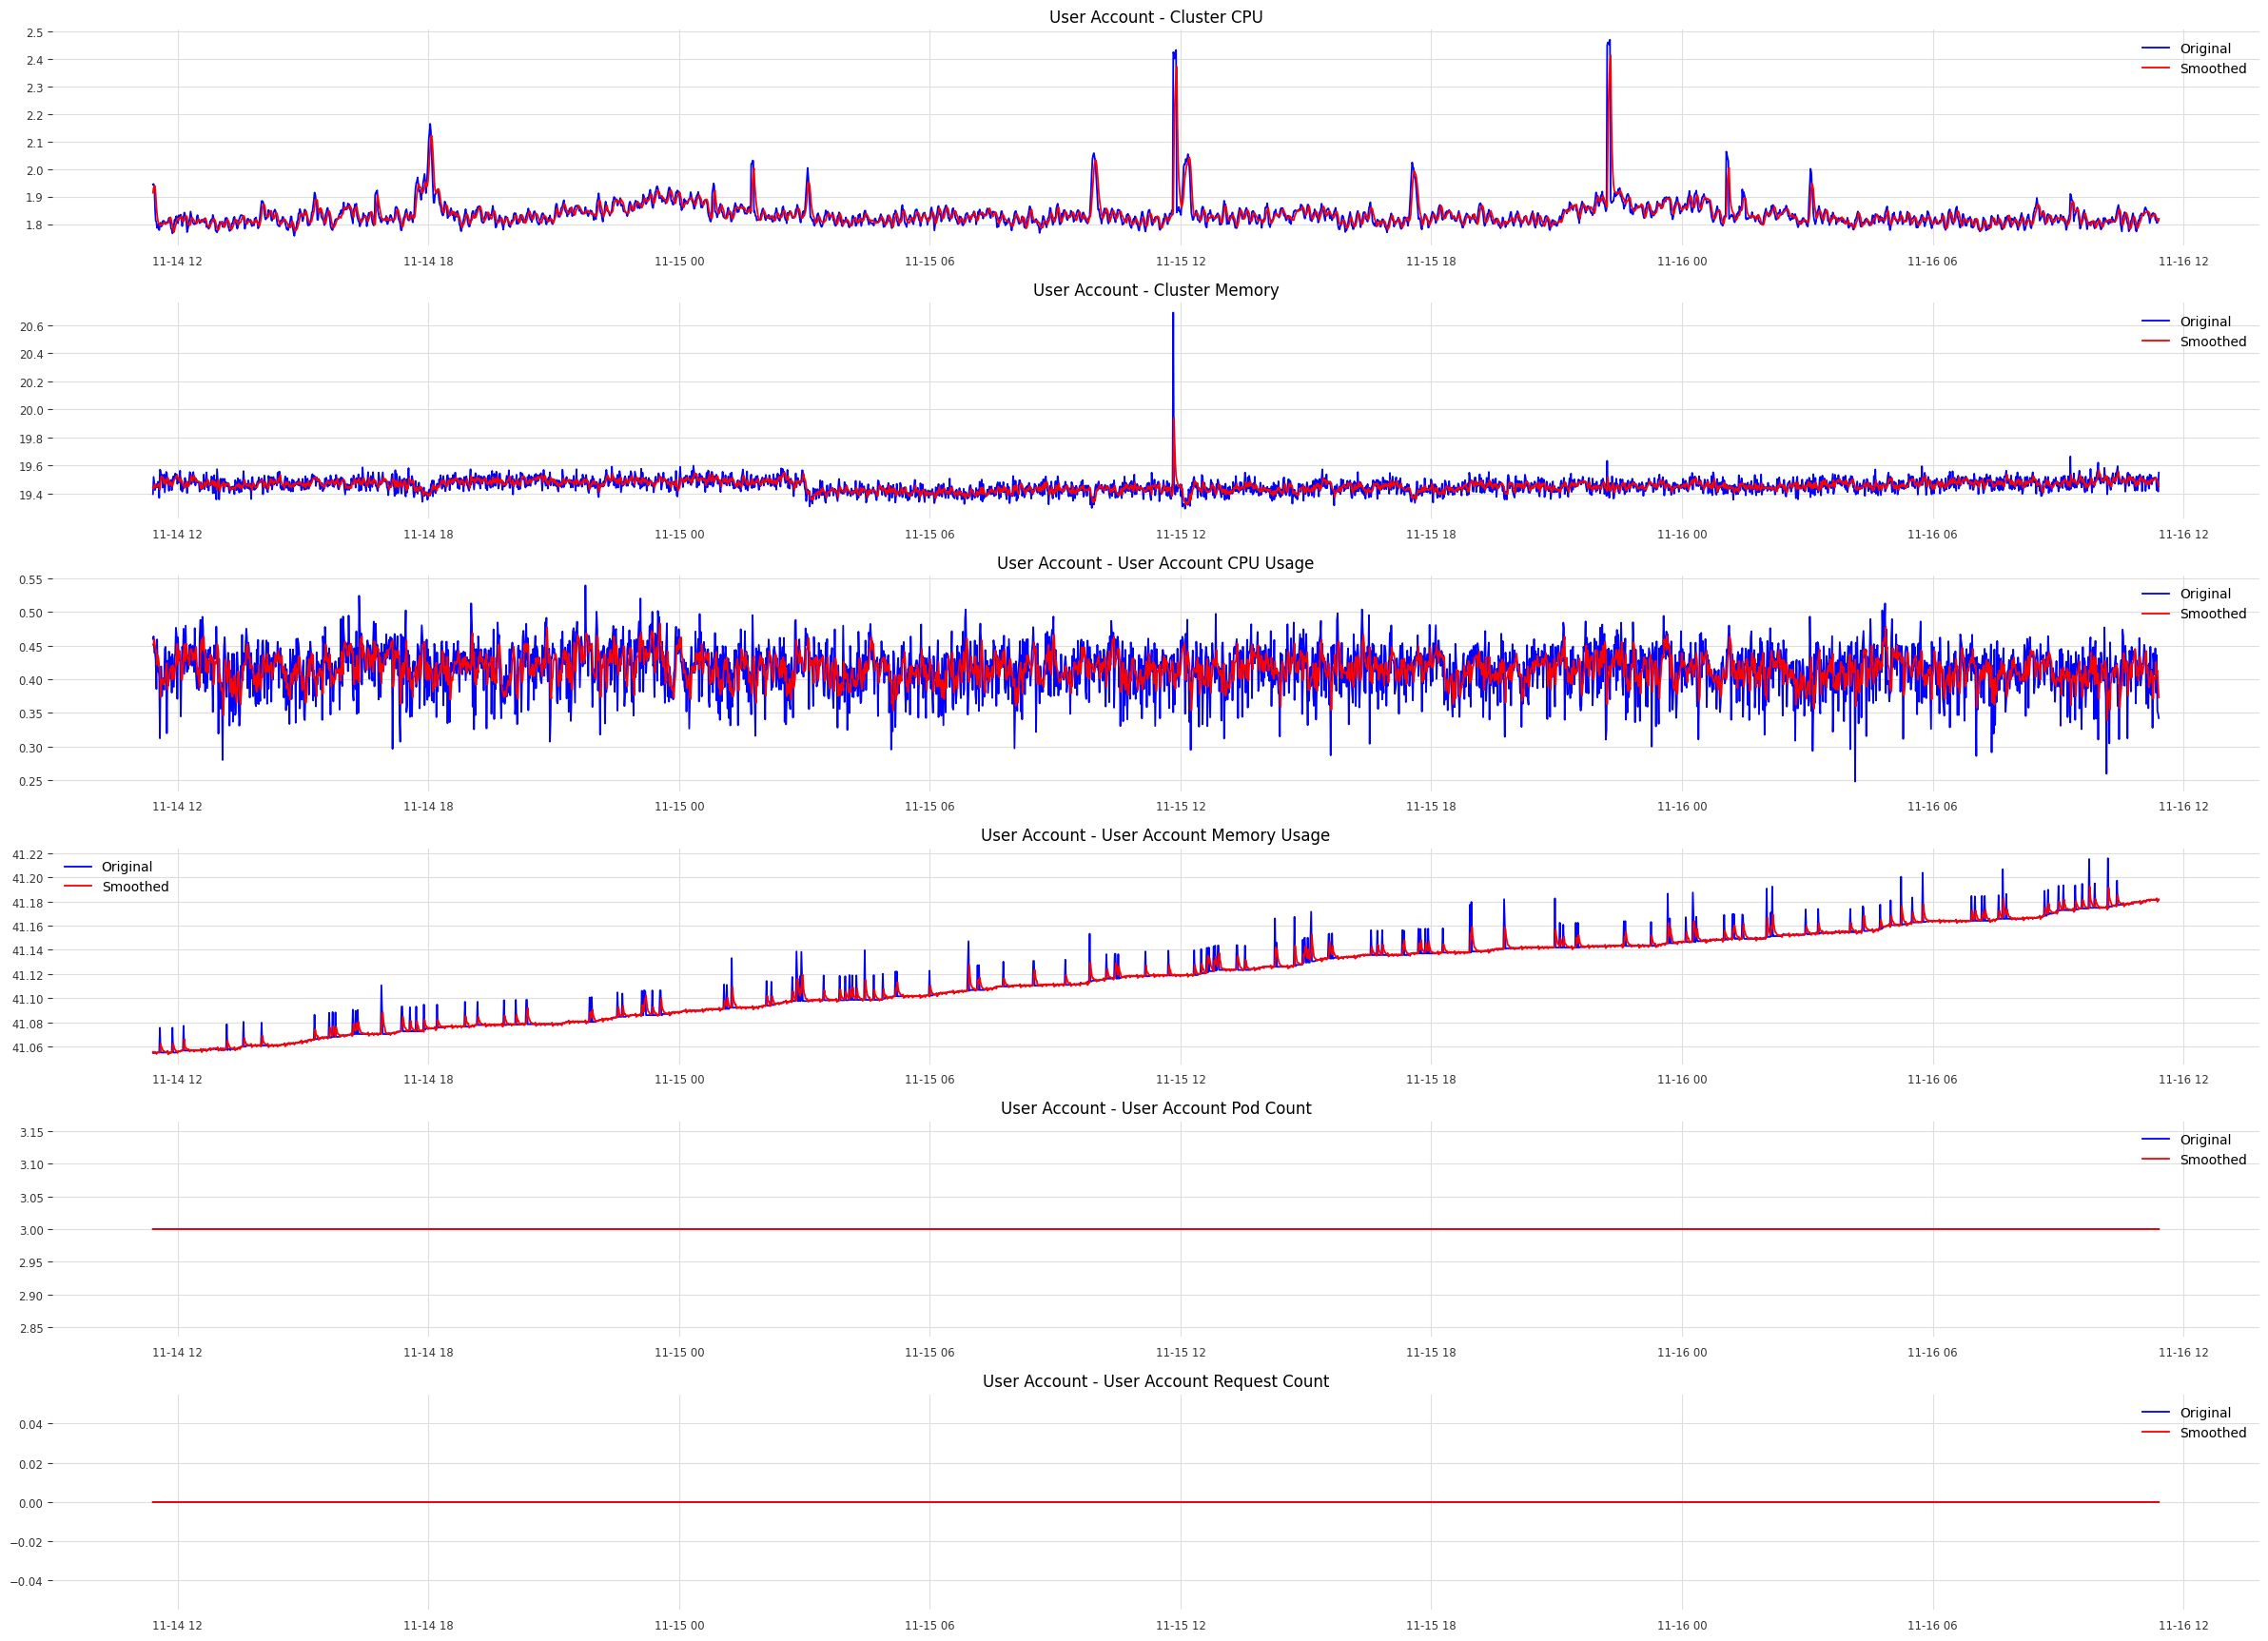

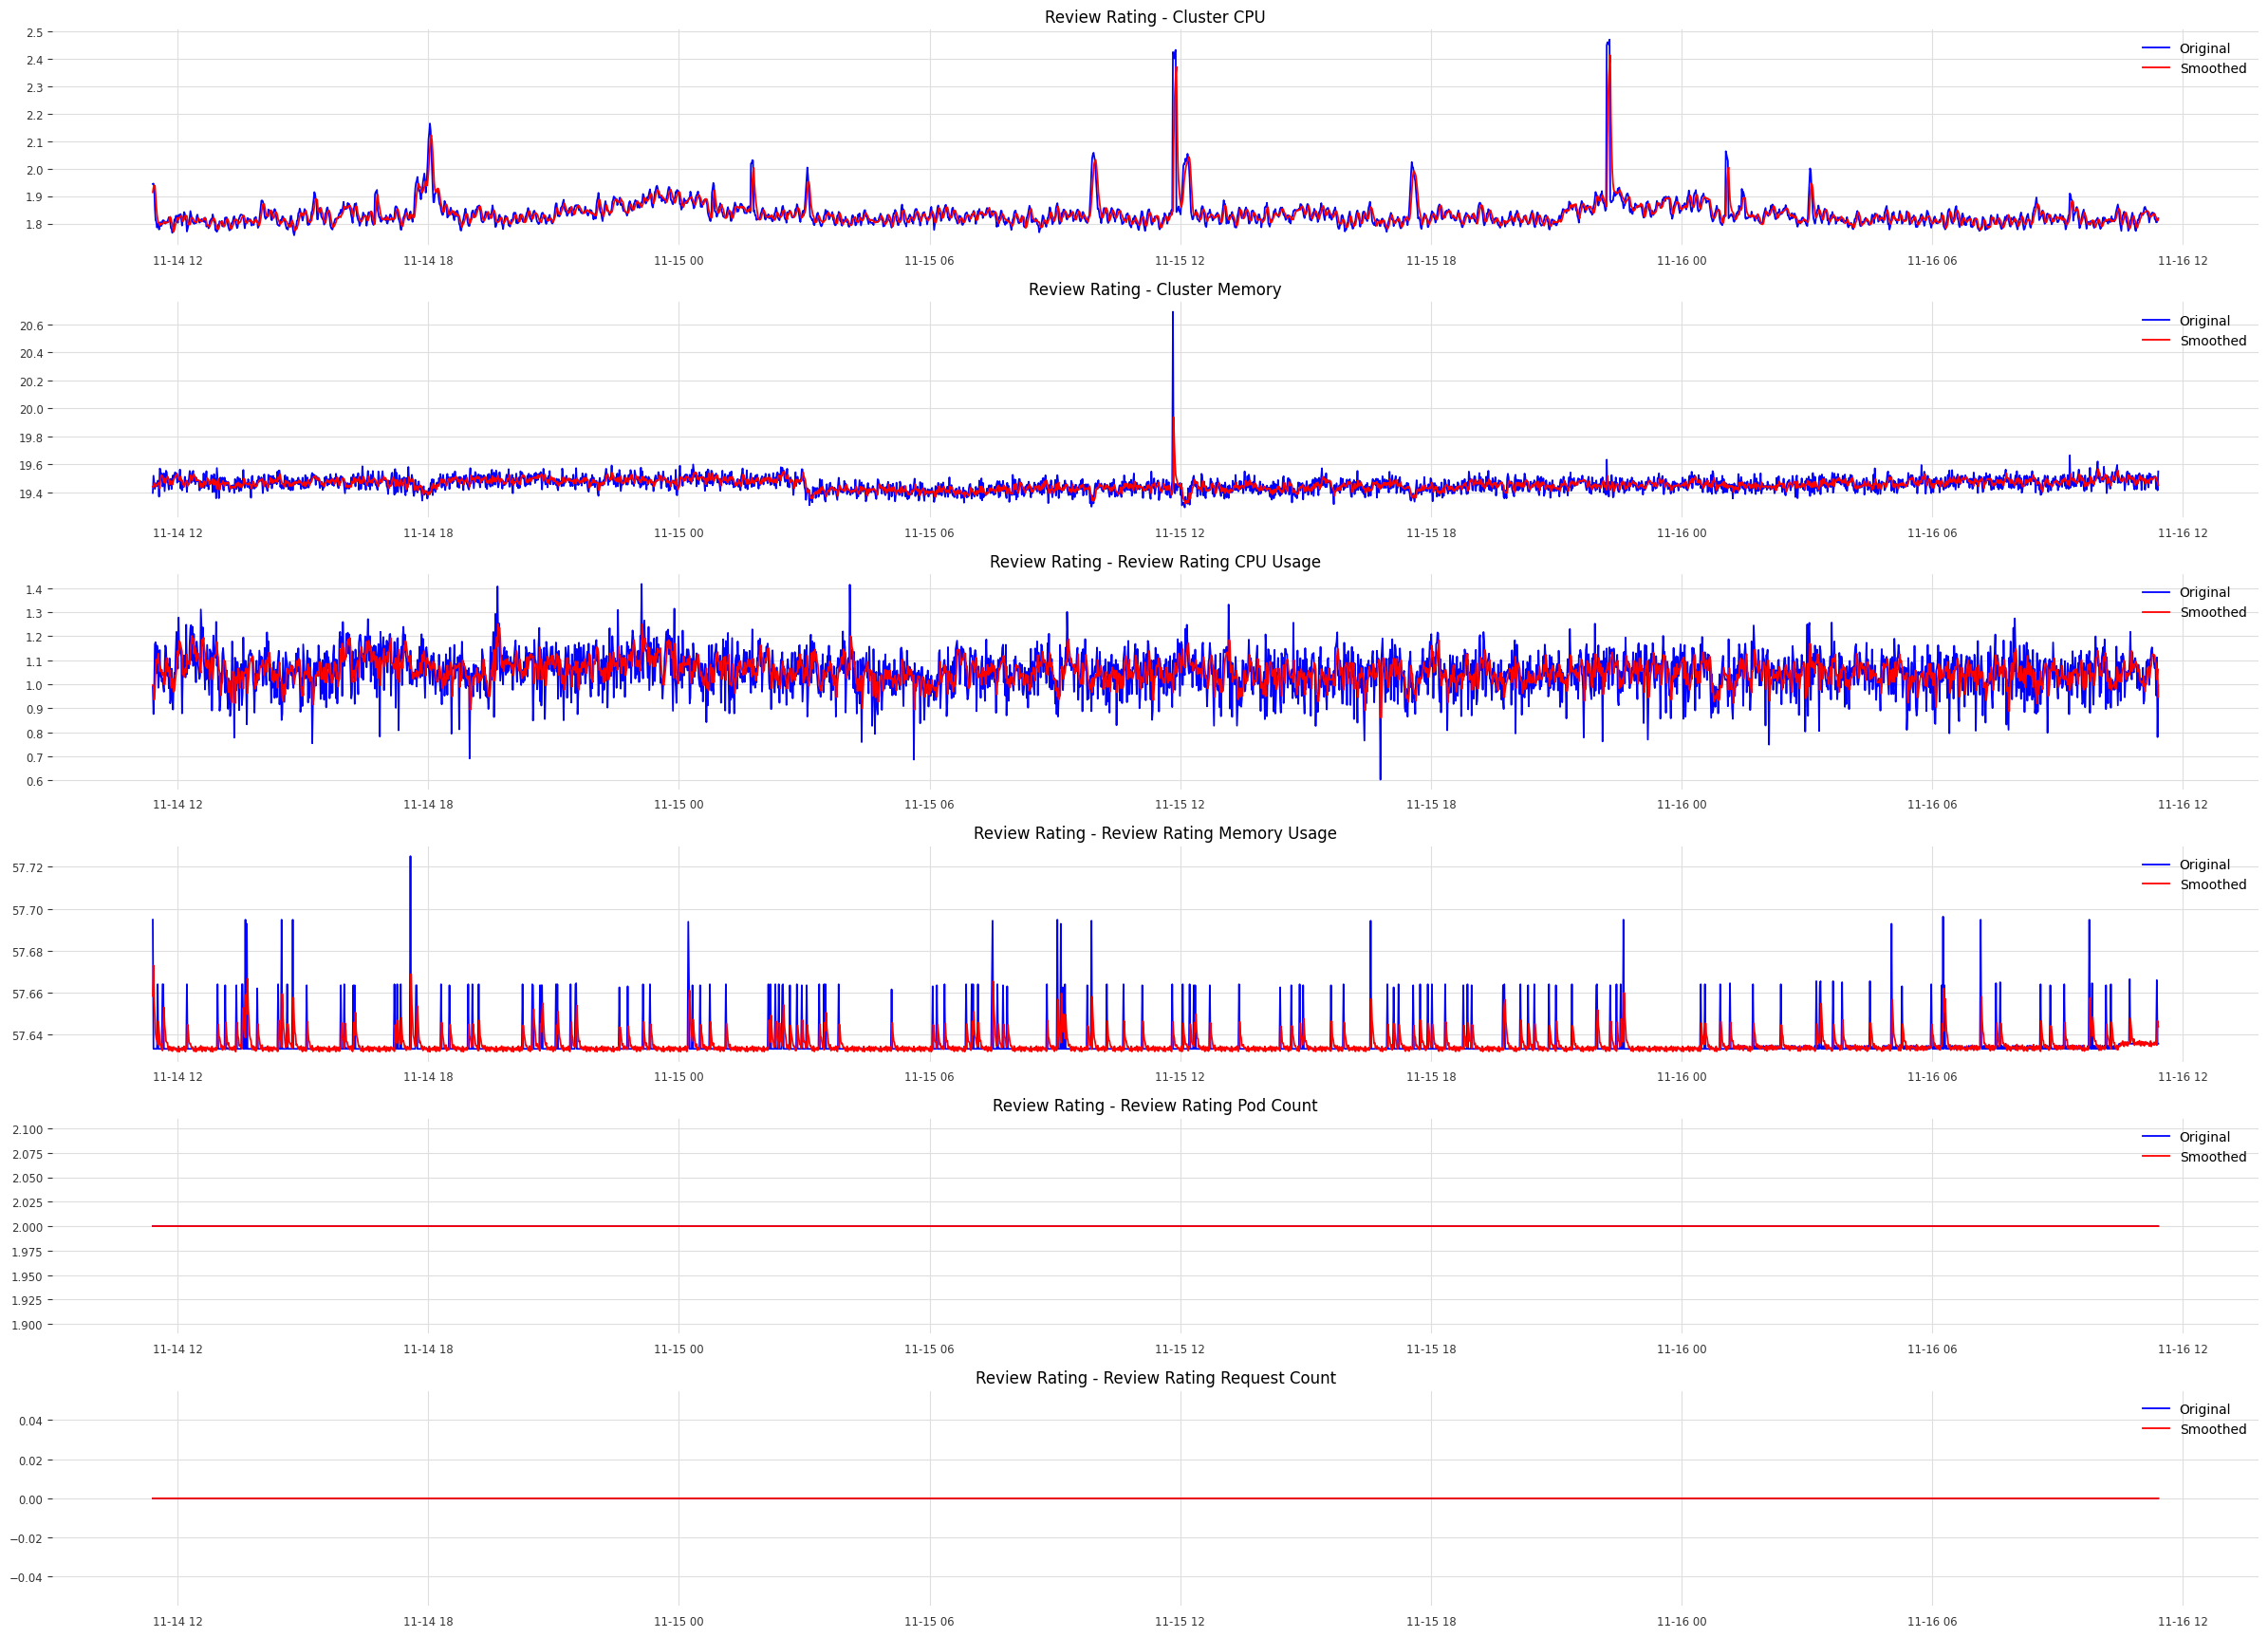

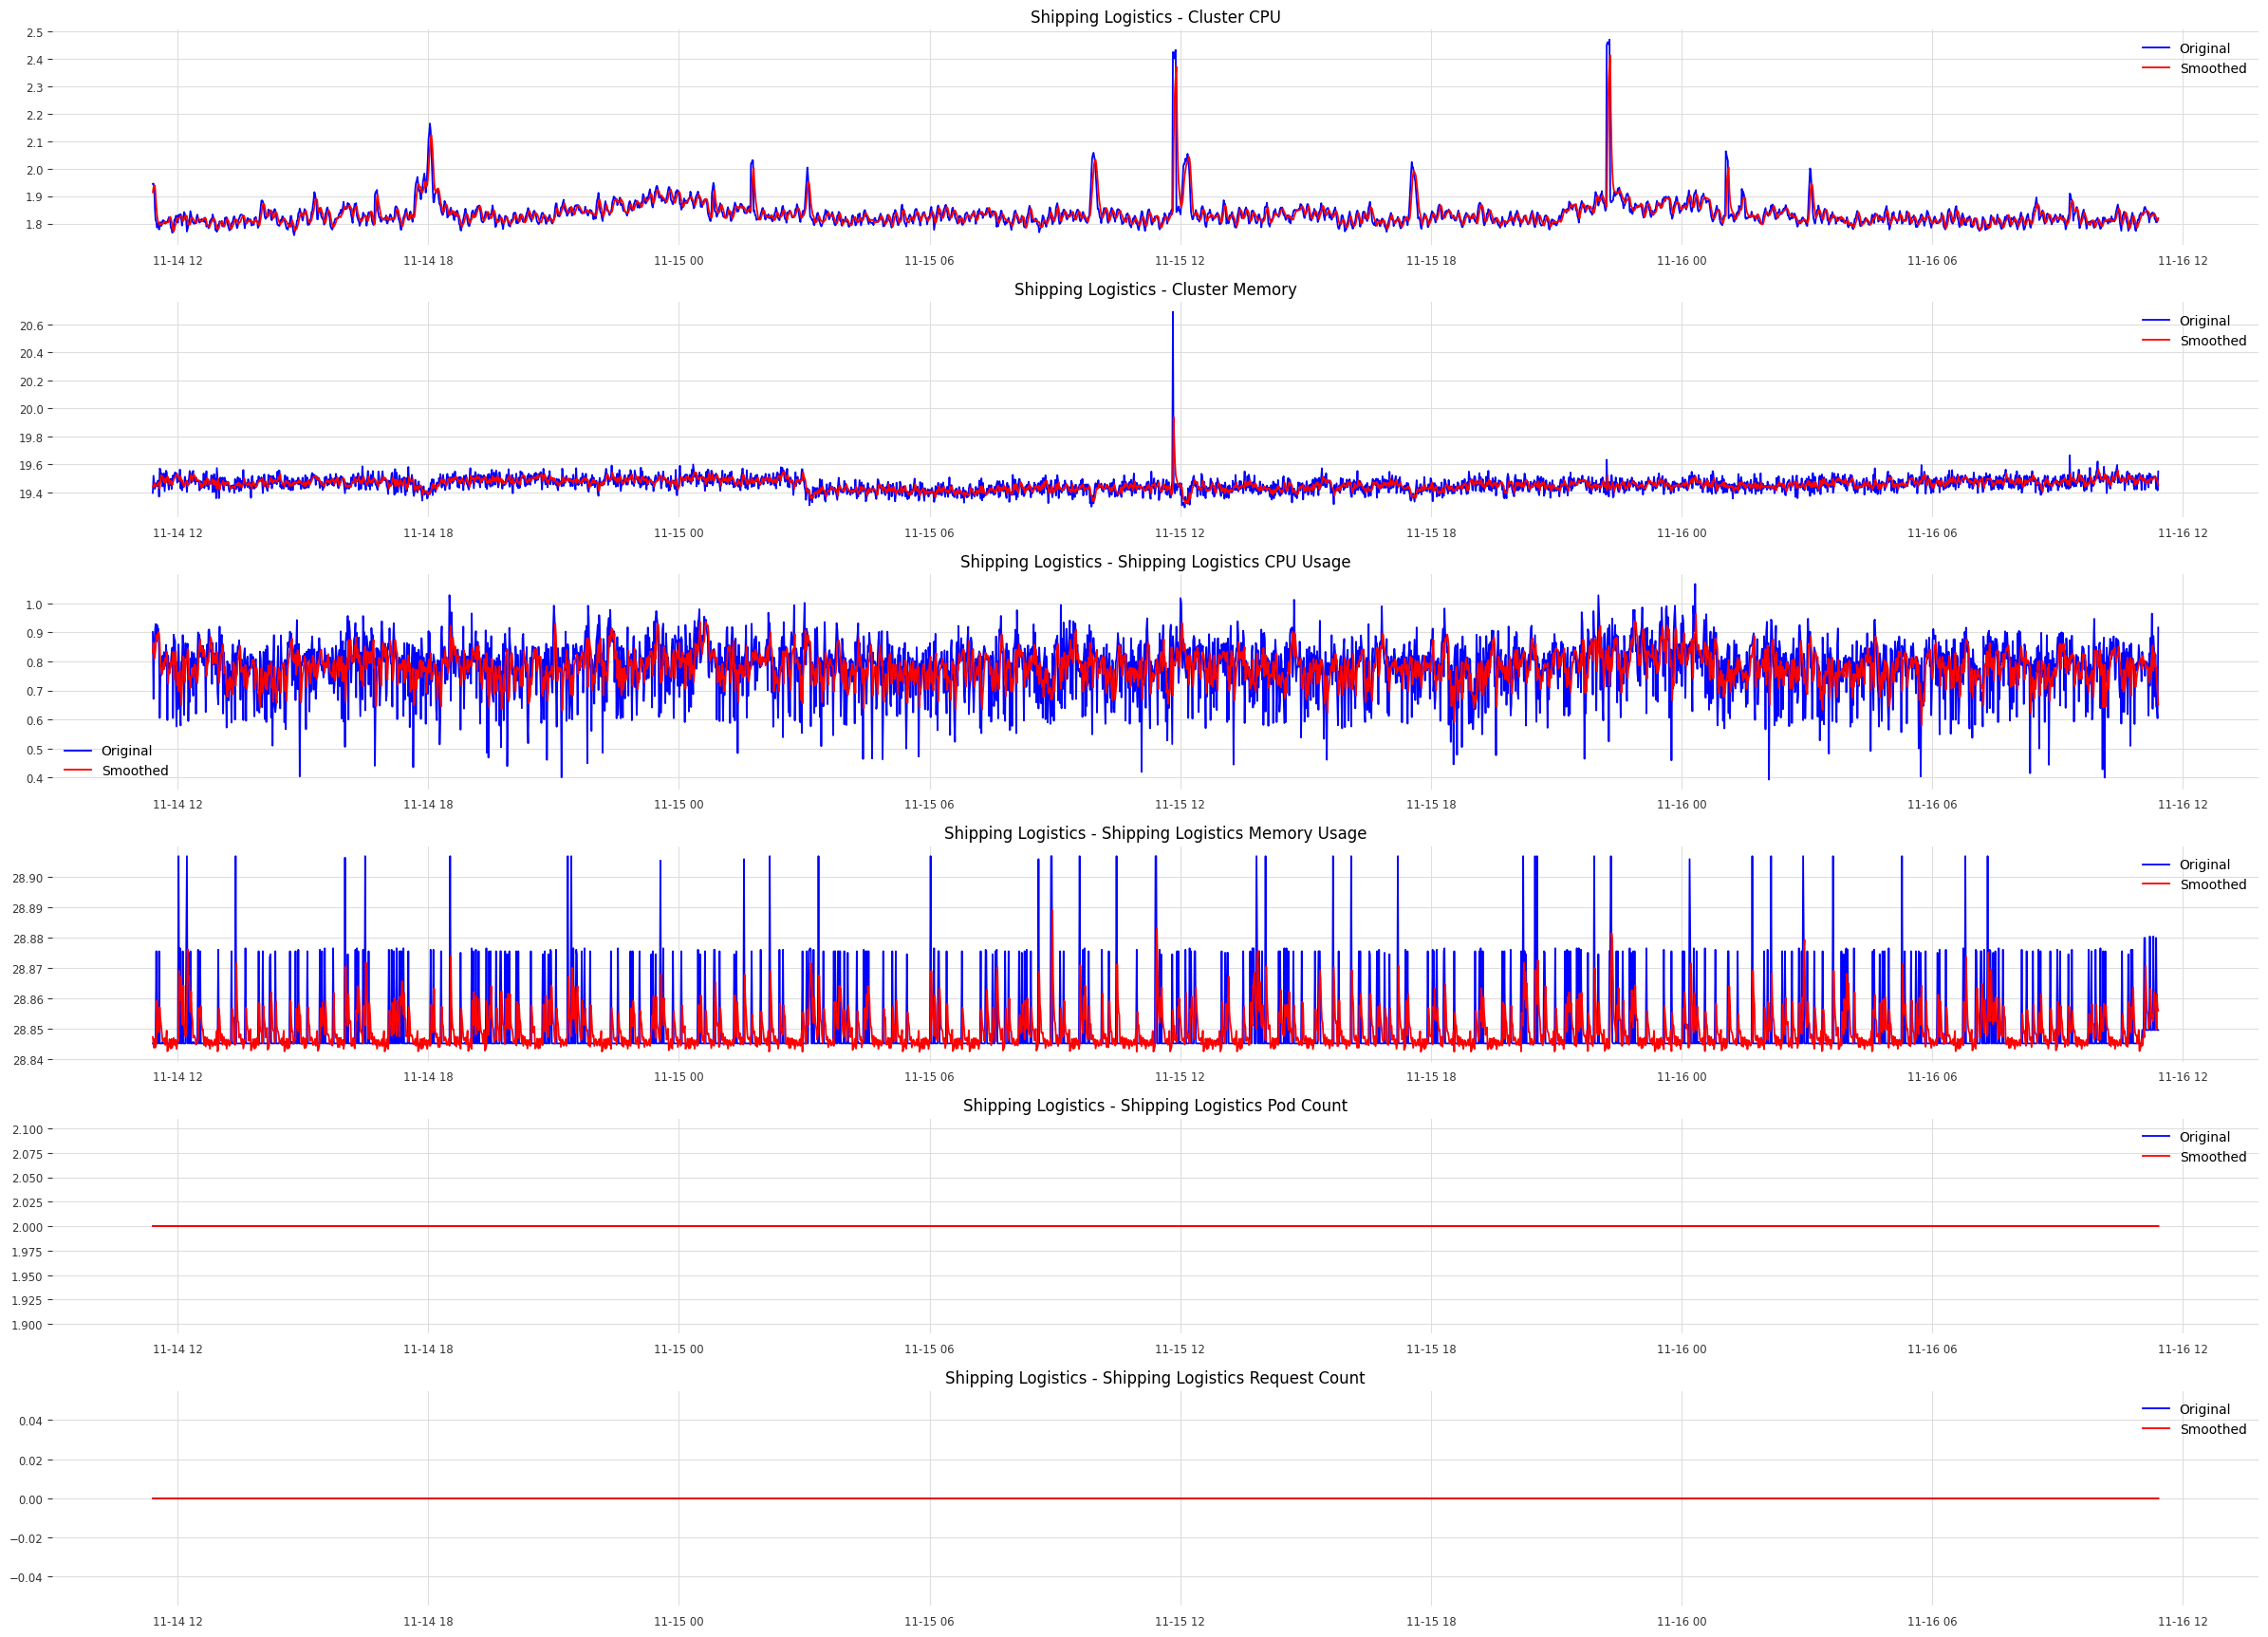

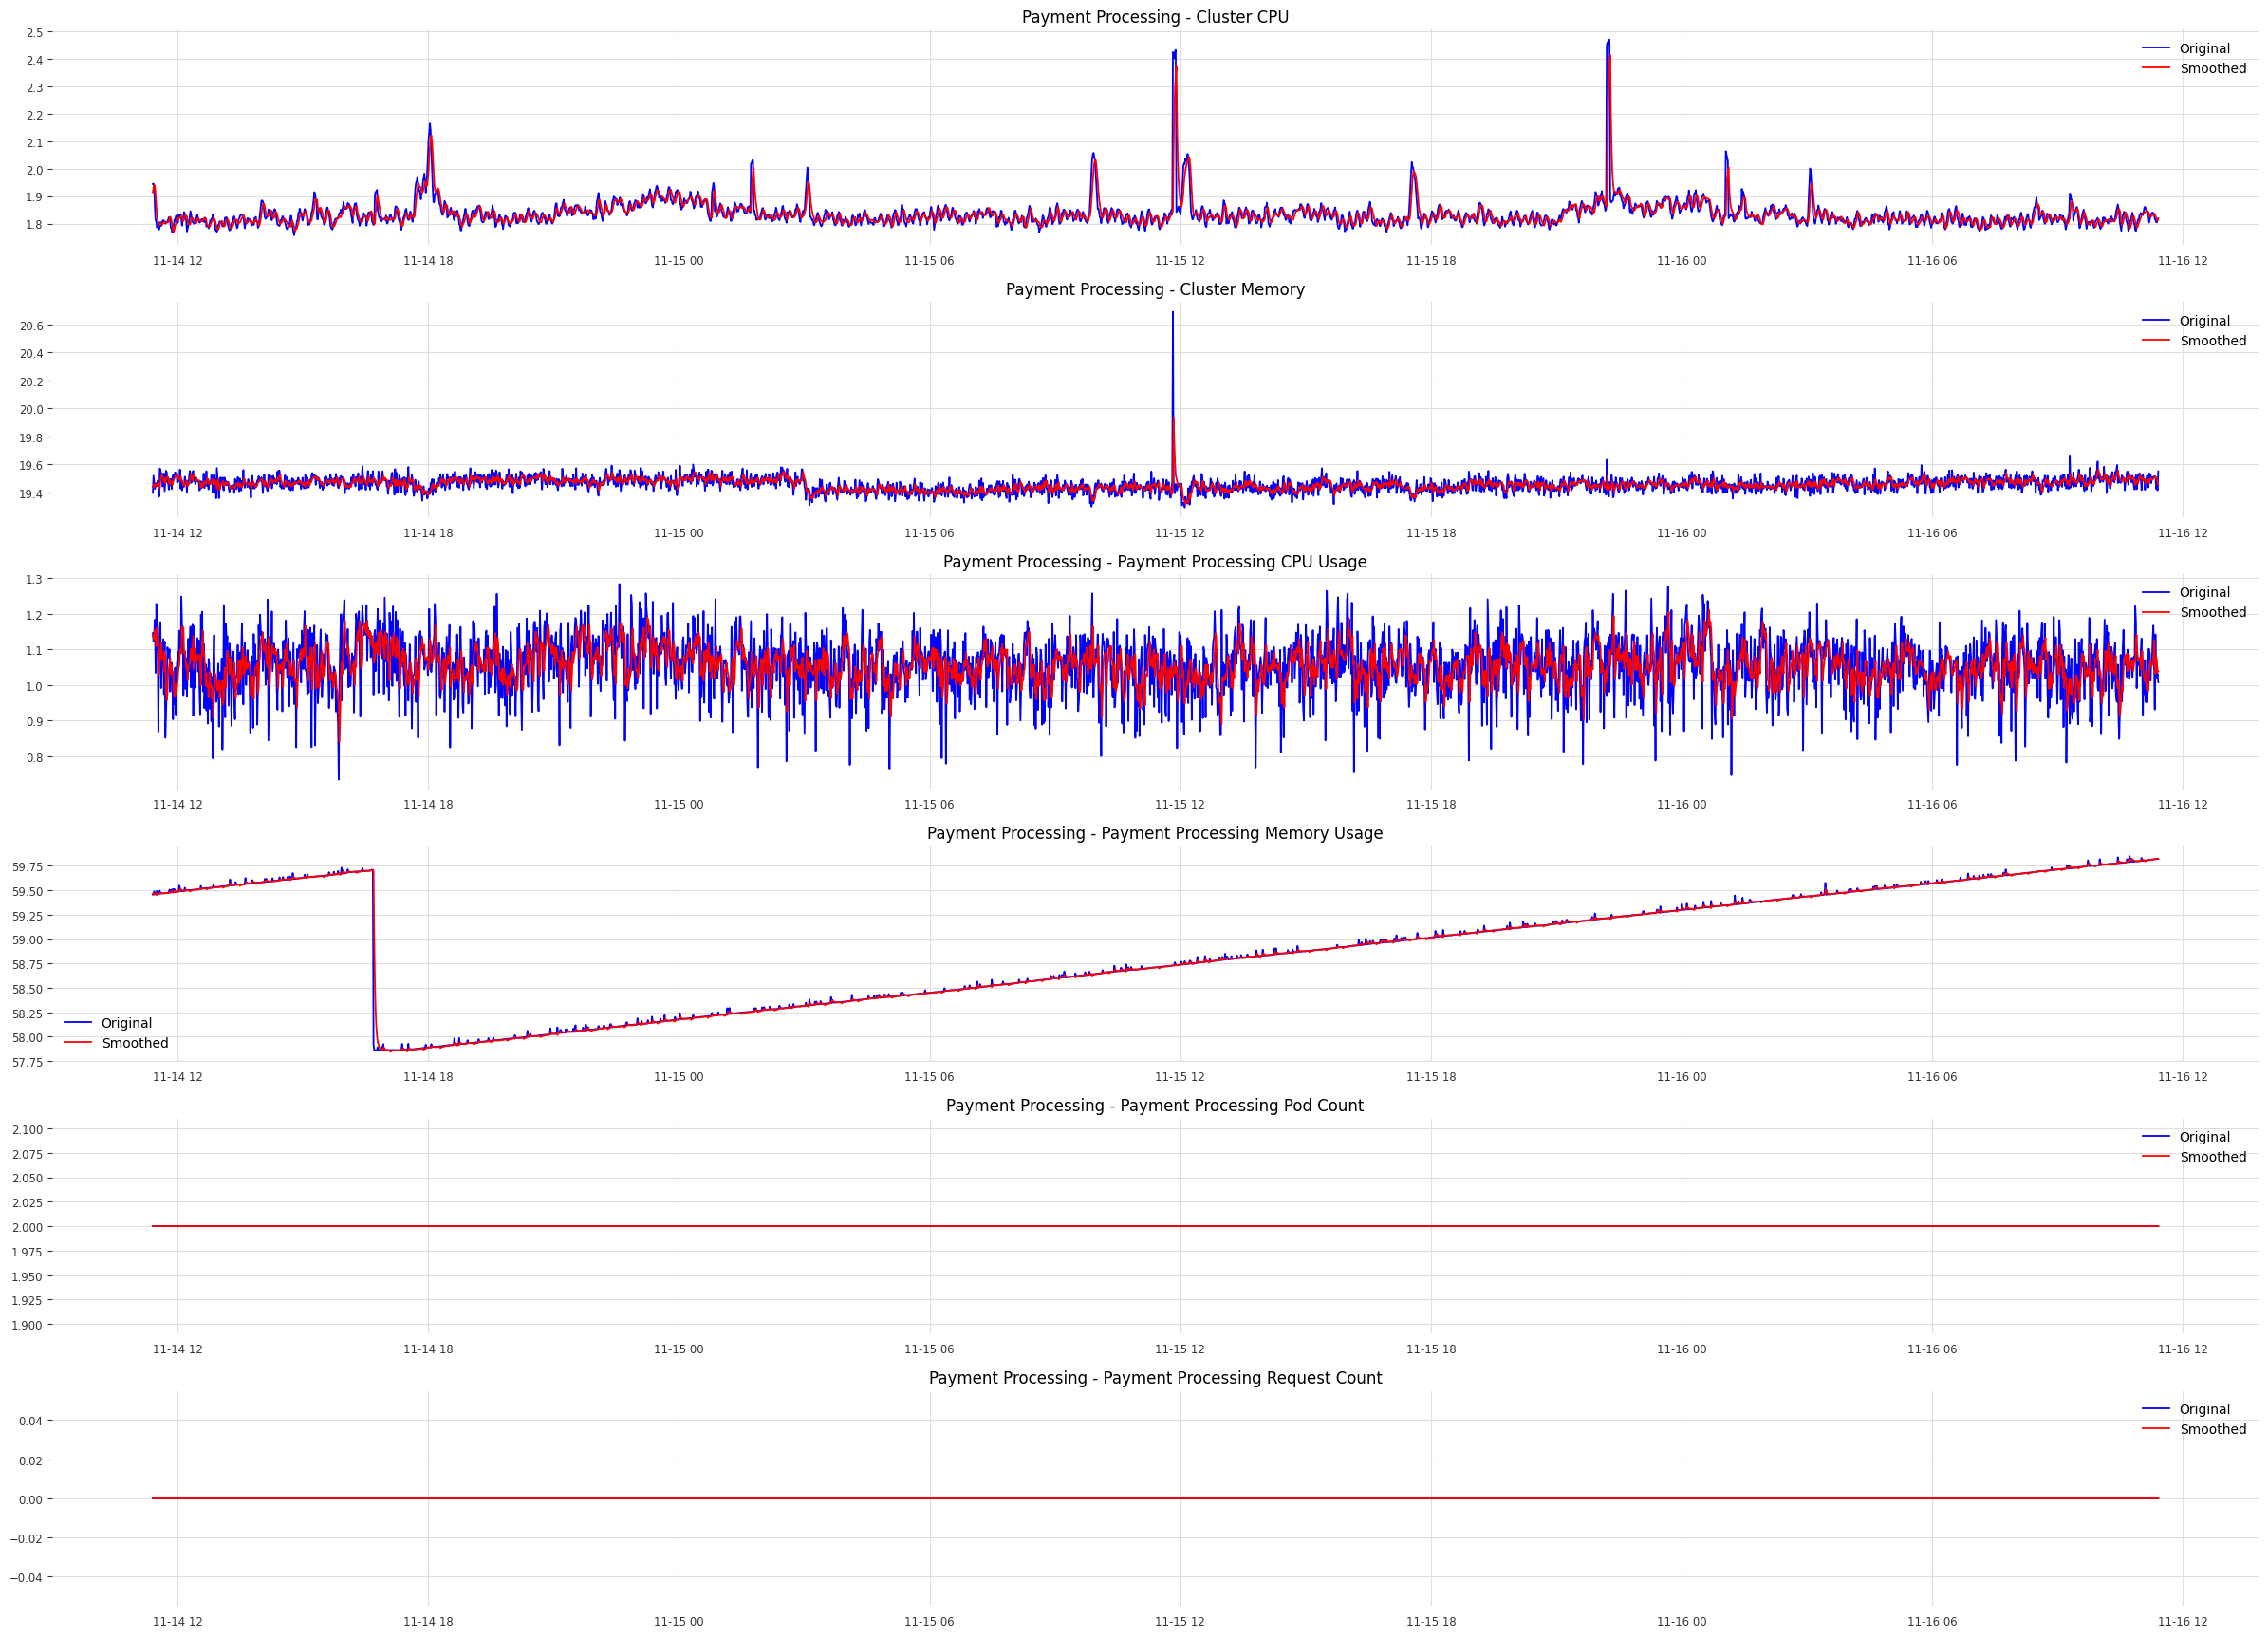

Length of pred_input for 5xx_failures: 2401


ValueError: All input series must have length >= `input_chunk_length` (2880).

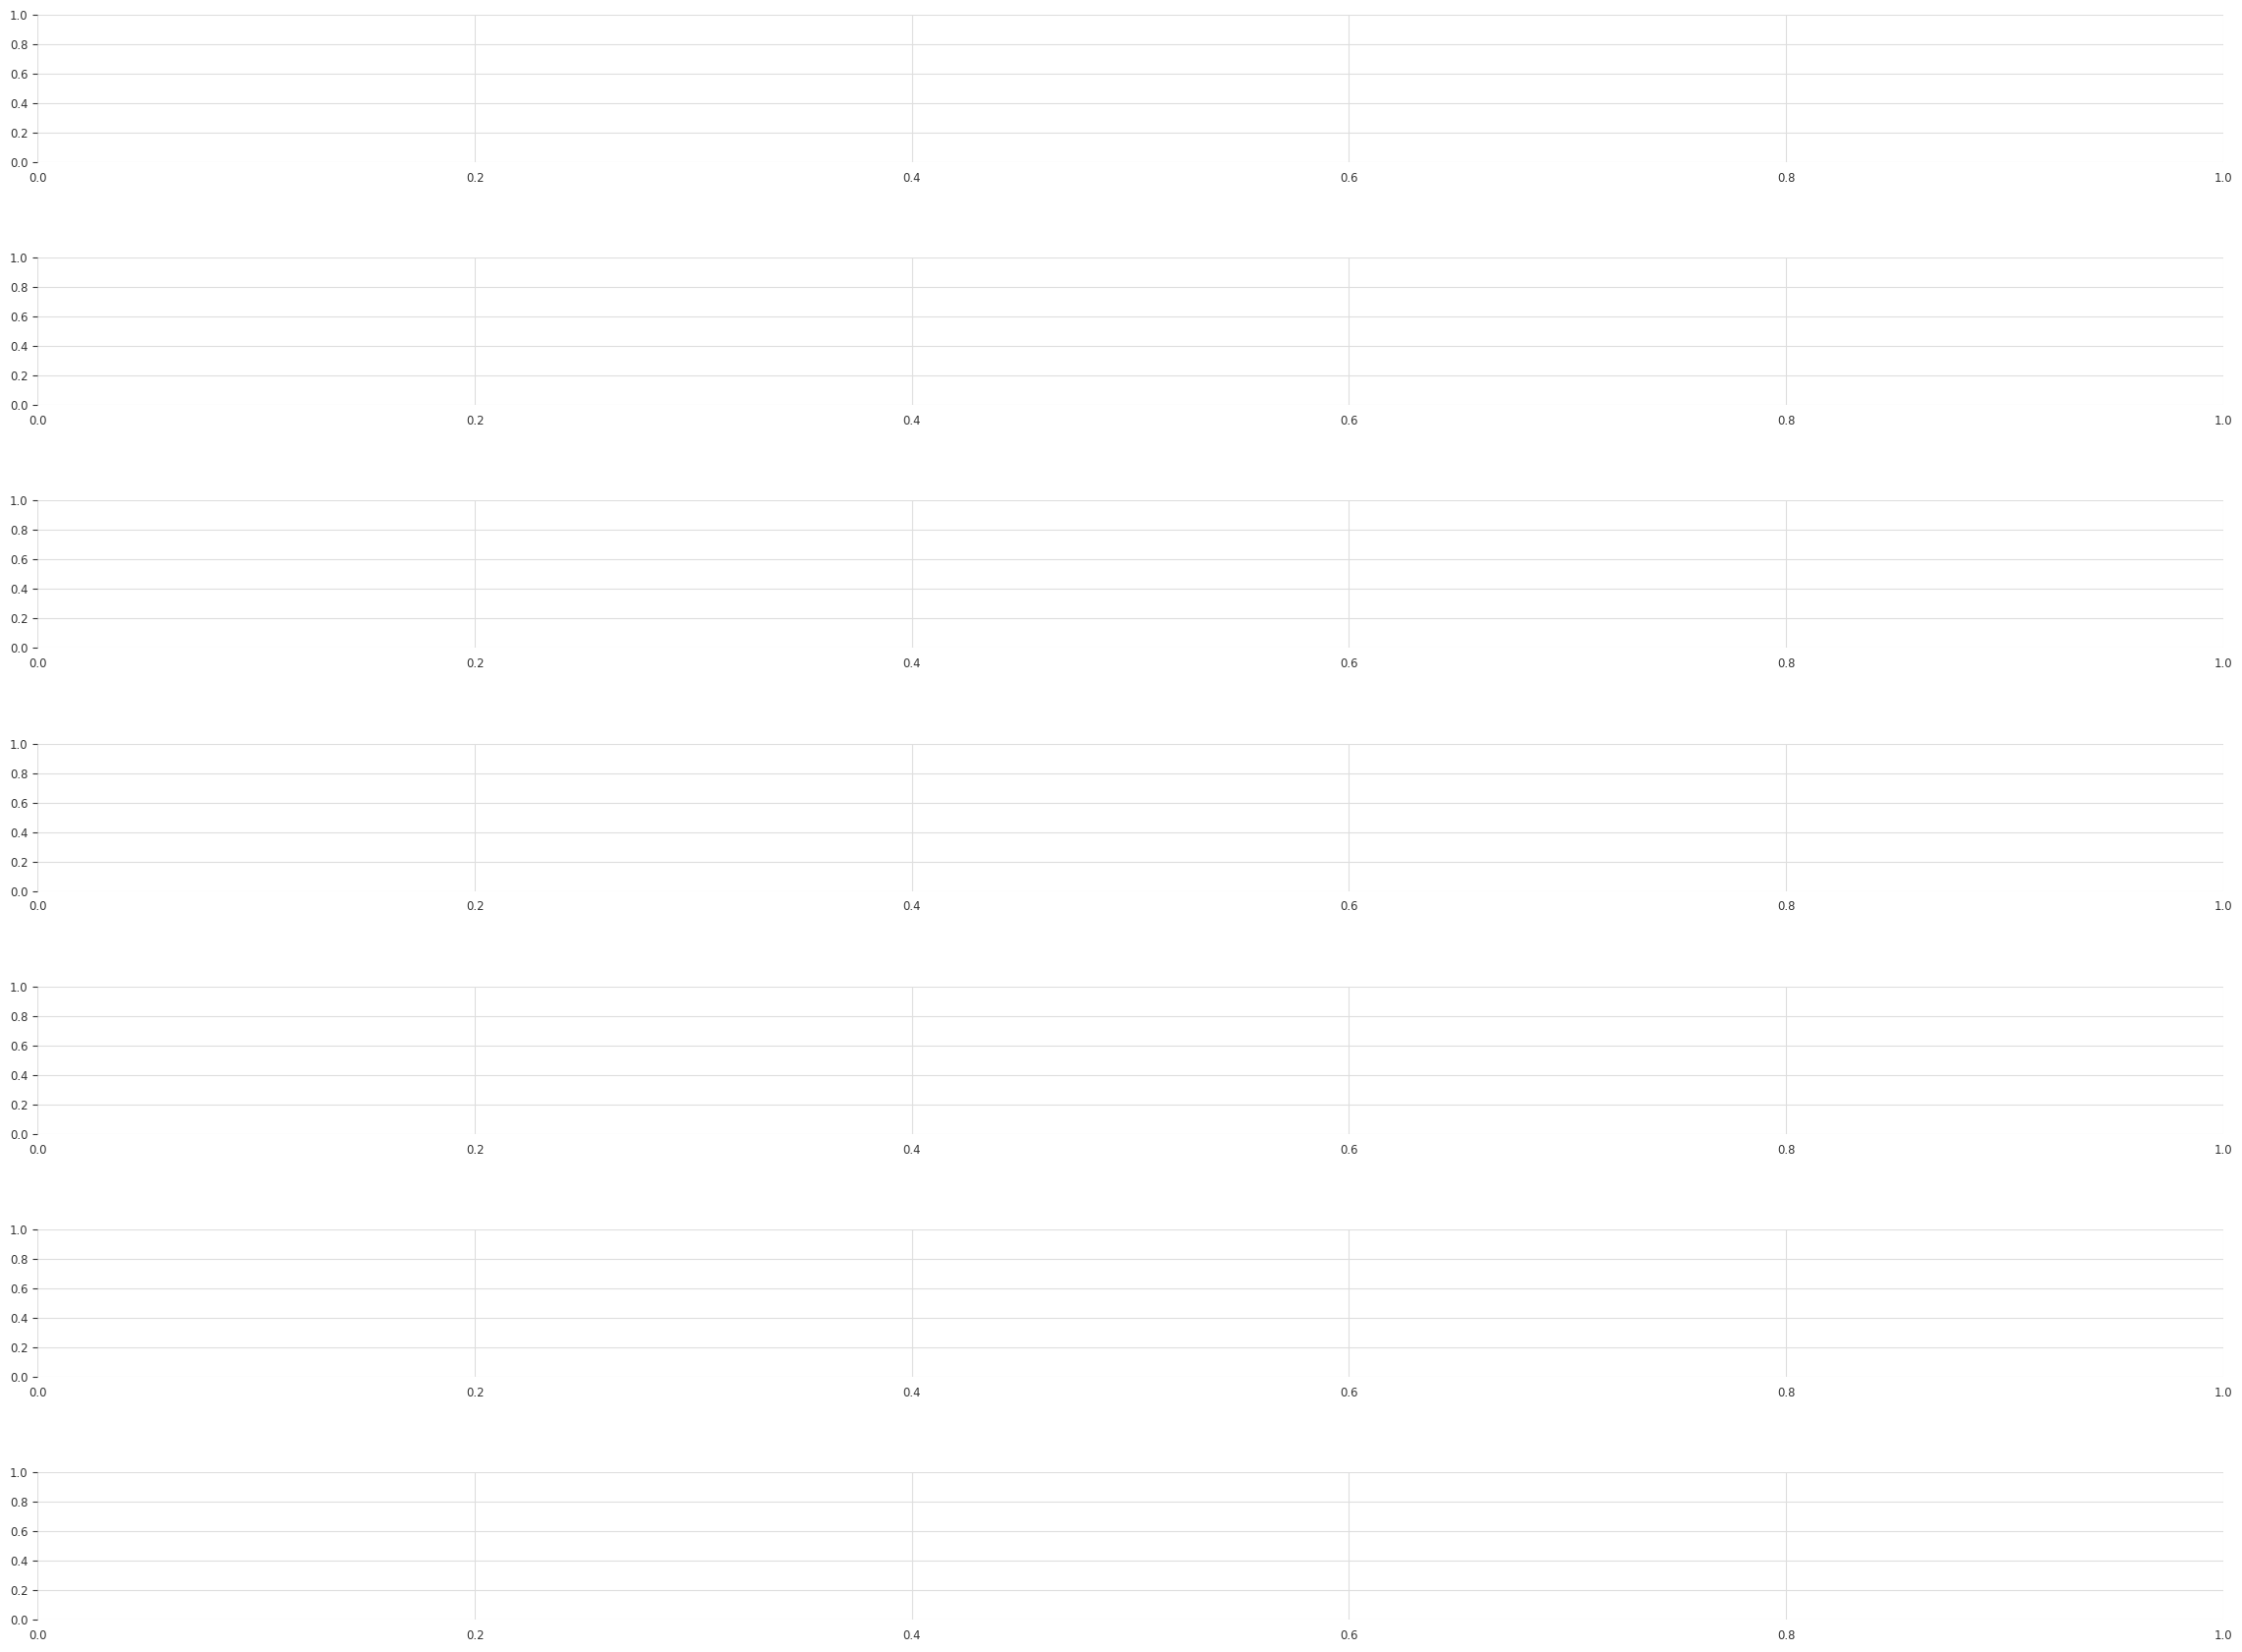

In [44]:
# Constants
FILE_PATH = 'grafana_data.csv'
GRAFANA_URL = "http://localhost:3000/api/datasources/proxy/1/api/v1/query_range"  # Update with your endpoint
API_KEY = "###"  # Replace with your Grafana API key

fetch_and_process_grafana_data(FILE_PATH, GRAFANA_URL, API_KEY)

order_df, product_df, user_df, reviews_df, shipping_df, payment_df = load_data(file_path)
seasonal_periods = 24

# Call the data smoothing function after loading the data
order_smoothed, product_smoothed, user_smoothed, reviews_smoothed, shipping_smoothed, payment_smoothed = data_smoothing(
    order_df, product_df, user_df, reviews_df, shipping_df, payment_df, seasonal_periods
)

# Execute the function and unpack the returned values
cpu_scaled, memory_scaled, request_count_scaled, pod_count_scaled, failures_scaled, cluster_cpu_scaled, cluster_memory_scaled, scalers_dict = preprocess_and_scale_features(
    order_smoothed, reviews_smoothed, payment_smoothed, user_smoothed, shipping_smoothed, product_smoothed
)

# Call the perform_forecasting function
service_dataframes = perform_forecasting(
    cpu_scaled,
    memory_scaled,
    request_count_scaled,
    pod_count_scaled,
    failures_scaled,
    cluster_cpu_scaled,
    cluster_memory_scaled,
    scalers_dict
)

classification_results = perform_classification(service_dataframes)
